#Imports and Dataset processing

In [122]:
import pandas as pd
import time
import numpy as np
import copy
from sympy import Symbol
from sympy.solvers import solve
pd.options.mode.chained_assignment = None
import csv
import warnings
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')

Import Dataset

### Get Protected attributes data

In [123]:
def get_protected_attr_data(data, protected_attr, y_label):
    # Extract necessary columns first
    columns = protected_attr + [y_label]
    protected_data = data[columns]

    # Add a 'cnt' column set to 1 for counting
    protected_data['cnt'] = 1

    # Now you can safely perform operations that depend on 'cnt'
    cnt_protected_with_y = protected_data.groupby(protected_attr + [y_label]).size().reset_index(name='cnt')
    cnt_protected = protected_data.groupby(protected_attr).size().reset_index(name='cnt')

    return cnt_protected_with_y, cnt_protected, protected_data


### Get node parents and counts in regions

In [124]:
# GET PARENTS and counts of regions
def get_parents_and_cnt_regions(data, protected_att, label):

    grrpby_data_lst = []
    for i in range(len(protected_att)):
        grp_names = copy.copy(protected_att)

        del grp_names[i]

        grp_names.append(label)
        temp_df = data.groupby(grp_names)['cnt'].count()
        grrpby_data_lst.append(temp_df)
    return grrpby_data_lst

### Construct Hierarchy

In [125]:
def construct_hierarchy(protected_attributes):
    hierarchy = {}
    for i in range(1, len(protected_attributes) + 1):
        for combo in itertools.combinations(protected_attributes, i):
            hierarchy[len(hierarchy)] = list(combo)
    return hierarchy



## Calculate ratio rn




In [126]:
def Calculate_ratio_rn(group_lst,parents, pos, neg):

    pos_cnt = 0
    neg_cnt = 0

    for i, df_groupby in enumerate(parents):

        temp_group_lst_pos = group_lst[:i] + group_lst[i+1:] + [1]
        temp_group_lst_neg = group_lst[:i] + group_lst[i+1:] + [0]


        # Assuming df_groupby is a DataFrame with appropriate indexing
        if tuple(temp_group_lst_pos) in df_groupby.keys():
          pos_cnt += df_groupby[tuple(temp_group_lst_pos)]

        if tuple(temp_group_lst_neg) in df_groupby.index:
            neg_cnt += df_groupby[tuple(temp_group_lst_neg)]


    # calculate pos, neg vals for ratio
    pos_val = pos_cnt - len(parents)* pos
    neg_val = neg_cnt - len(parents)* neg

    return -1 if neg_val == -1 or (neg_val == 0 and pos_val == 0) else 0 if pos_val == 0 or neg_val == 0 else pos_val / neg_val


## Calculate ratio

In [127]:
def compute_ratio(data, att_vals, protected_att, y_label):

    filtered_data = copy.deepcopy(data)
    # keep only the pos and neg count of the row
    for i in range(len(att_vals)):
      filtered_data = filtered_data[filtered_data[protected_att[i]] == att_vals[i]]

    # count the neg and pos examples
    total = filtered_data['cnt'].sum()
    pos = filtered_data[filtered_data[y_label] == 1]['cnt'].sum()
    neg = total - pos

    return pos, neg, total


Handle Imbalance

In [128]:
def handle_imbalance(ratio_rn, pos, neg, group_lst, need_pos, need_neg, imbalance_threshold):
    # Initialize imbalance status
    is_imbalance = 0

    # Determine imbalance based on ratio_rn
    if ratio_rn != -1:
        if ratio_rn == 0:
            # If ratio_rn is zero, check if there's a complete imbalance
            is_imbalance = 1 if neg == 0 and pos > 0 else 2 if pos == 0 and neg > 0 else 0
        else:
            # Calculate the actual ratio
            ratio_r = pos / neg
            # Determine if the imbalance exceeds the threshold
            if ratio_r - ratio_rn > imbalance_threshold:
                is_imbalance = 1
            elif ratio_rn - ratio_r > imbalance_threshold:
                is_imbalance = 2

    # Update need_neg or need_pos lists based on the imbalance status
    if is_imbalance == 1:
        if group_lst not in need_neg:
            need_neg.append(group_lst)
        else:
            print(f"{group_lst} is already in need_neg")
    elif is_imbalance == 2:
        if group_lst not in need_pos:
            need_pos.append(group_lst)
        else:
            print(f"{group_lst} is already in need_pos")


## IBS Algorithm


In [129]:
def implicit_biased_set_identification(data, protected_attr, y_label, imbalance_threshold, k, verbose=True):
  """Identifies sets with potential biases based on protected attributes."""
  start_time = time.time()
  hierarchy = construct_hierarchy(protected_attr)
  attrs = []

  for curr_protected_att in reversed(list(hierarchy.values())):

    # get data only with the currect protected attributes
    grpby_protected_y, grpby_protected, protected_data = get_protected_attr_data(data, curr_protected_att, y_label)

    #filter groups smaller than k
    grpby_protected = grpby_protected[grpby_protected['cnt'] > k]

    # count the groups of all the parents
    parents = get_parents_and_cnt_regions(protected_data, curr_protected_att, y_label)

    need_pos = []
    need_neg = []

    for index, row in grpby_protected.iterrows():
        group_lst = [row[att] for att in curr_protected_att]
        pos, neg, total = compute_ratio(grpby_protected_y, group_lst, curr_protected_att, y_label)
        is_imbalance = 0
        if(total > k ):
          ratio_rn = Calculate_ratio_rn(group_lst, parents, pos, neg)

          handle_imbalance(ratio_rn, pos, neg, group_lst, need_pos, need_neg, imbalance_threshold)

    if verbose:
      att_str = ' & '.join(curr_protected_att)
      attrs.append({
        'x_label': att_str,
        'need_pos_values': len(need_pos),
        'need_neg_values': len(need_neg),
        'need_total': len(need_neg) + len(need_pos)
      })


  end_time = time.time()
  excute_time = end_time - start_time

  if (len(attrs) is not 0):
    max_update_vals = max(attrs, key=lambda x: x['need_total'])['need_total'] if len(attrs) is not 0 else 0

    print('Subgroup with most required total updates is: ', max(attrs, key=lambda x: x['need_total'])['x_label'])

  attrs = sorted(attrs, key=lambda x: x["need_total"])

  # Create scatter plot
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=[att['x_label'] for att in attrs], y=[att['need_pos_values'] for att in attrs], color='blue', marker='^', label='Need Positive')
  sns.scatterplot(x=[att['x_label'] for att in attrs], y=[att['need_neg_values'] for att in attrs], color='red', marker='v', label='Need Negative')
  sns.scatterplot(x=[att['x_label'] for att in attrs], y=[att['need_total'] for att in attrs], color='green', marker='o', label='Need Total')

  plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
  plt.xticks(rotation=90, ha="right")
  plt.xlabel("Subgroups of Protected Attributes")
  plt.ylabel("Need Pos / Need Neg")
  plt.title("Imbalance Identification Scatter Plot")
  plt.legend()
  plt.show()
  return excute_time, max_update_vals





# Run Dataset tests


In [130]:
def run_tests(X, check_cols, y):

  ks = []
  times = []
  thres = []
  maxs = []

  for i in range(10, 100, 10):
    print("K: ", i, "imbalance threshold: 0.1")
    ks.append(i)
    excute_time, _ = implicit_biased_set_identification(X, check_cols, y, 0.1, i, True)
    times.append(excute_time)

  for i in np.arange(0.1, 0.8, 0.1):
    print("imbalance threshold: ", i, "K: 30")
    thres.append(i)
    _, max_update_vals = implicit_biased_set_identification(X, check_cols, y, i, 30, True)
    maxs.append(max_update_vals)

  plt.figure(figsize=(10, 6))
  sns.lineplot(x=ks, y=times, color='blue', marker='o')

  plt.xticks(rotation=90, ha="right")
  plt.xlabel("K Values")
  plt.ylabel("Execution Time")
  plt.title("Runtime as a function of K")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10, 6))
  sns.lineplot(x=thres, y=maxs, color='blue', marker='o')

  plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
  plt.xticks(rotation=90, ha="right")
  plt.xlabel("Threshold")
  plt.ylabel("Max Total Updates Required")
  plt.title("Max Total Updates as a function of Imbalance Threshold")
  plt.legend()
  plt.show()

### German Credit Data dataset

K:  10 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


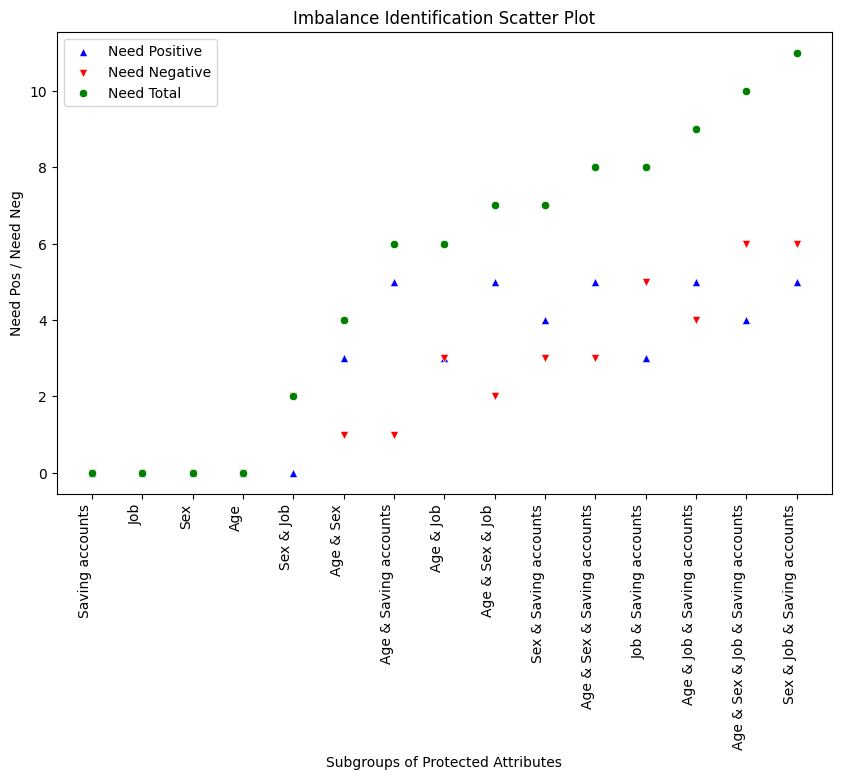

K:  20 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


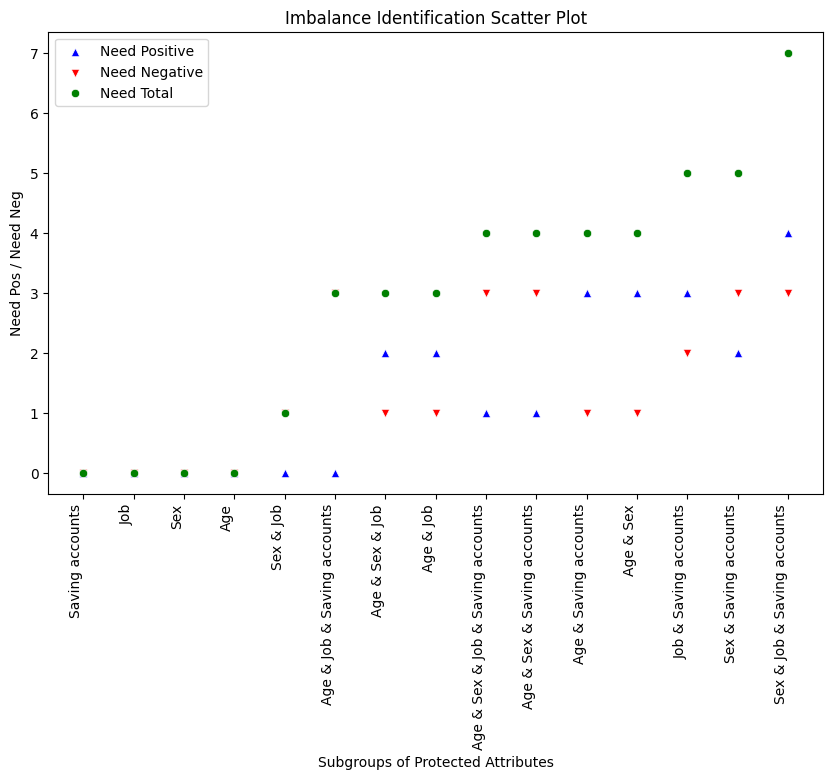

K:  30 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


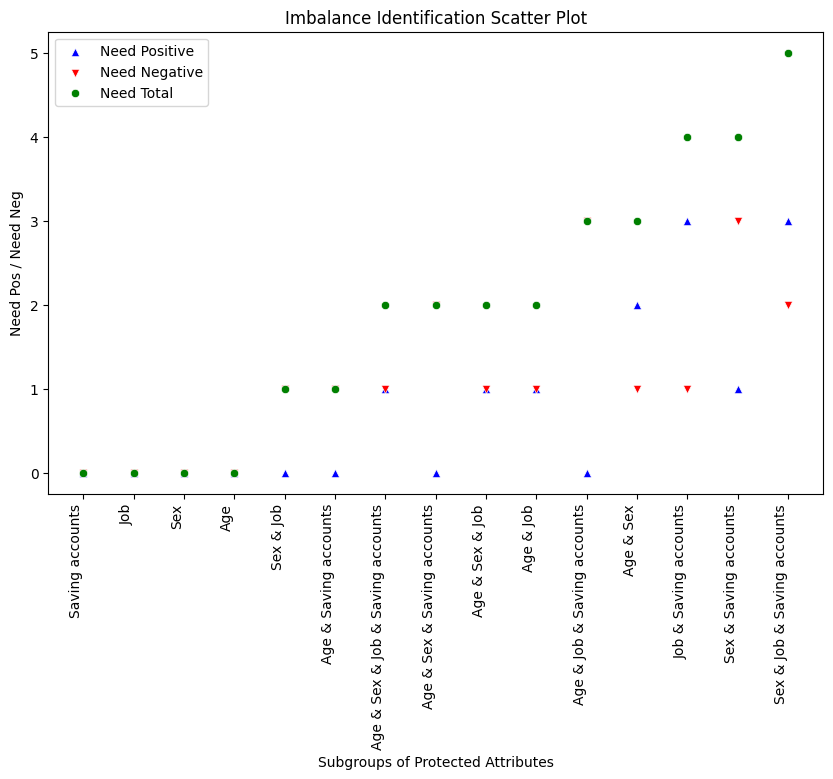

K:  40 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


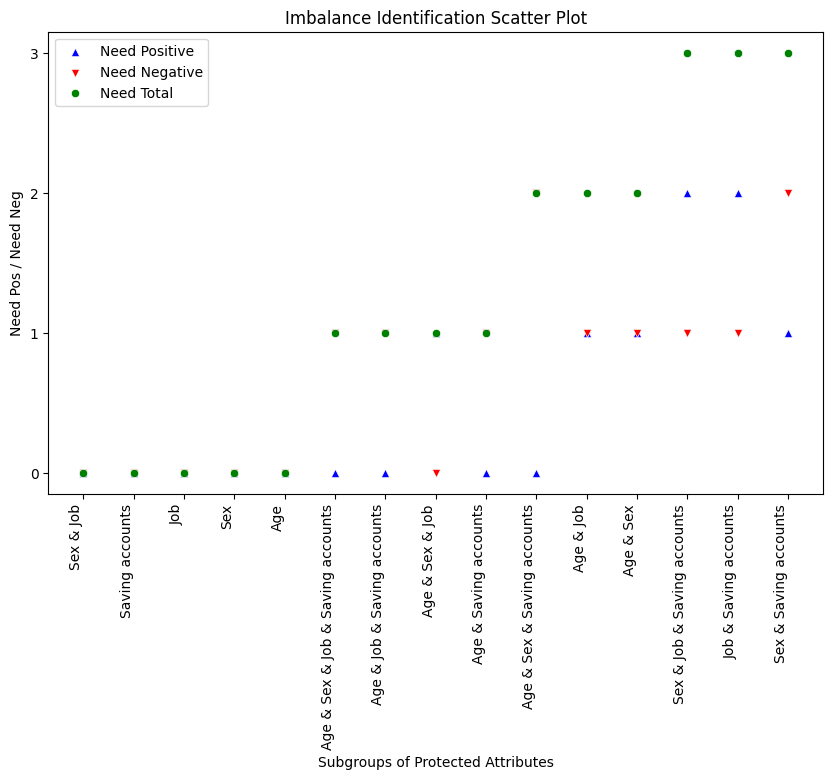

K:  50 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


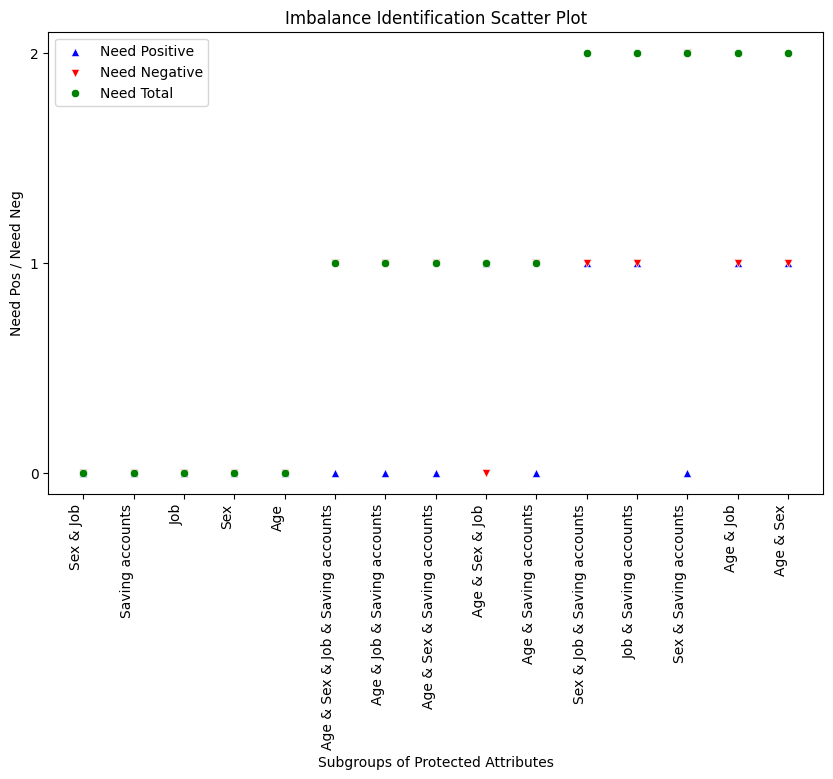

K:  60 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


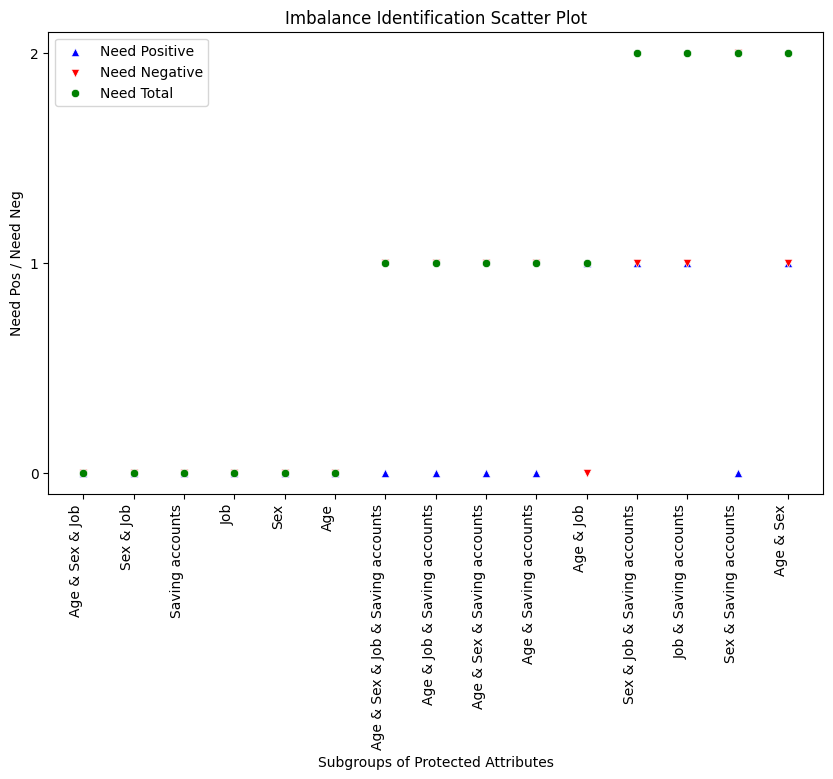

K:  70 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


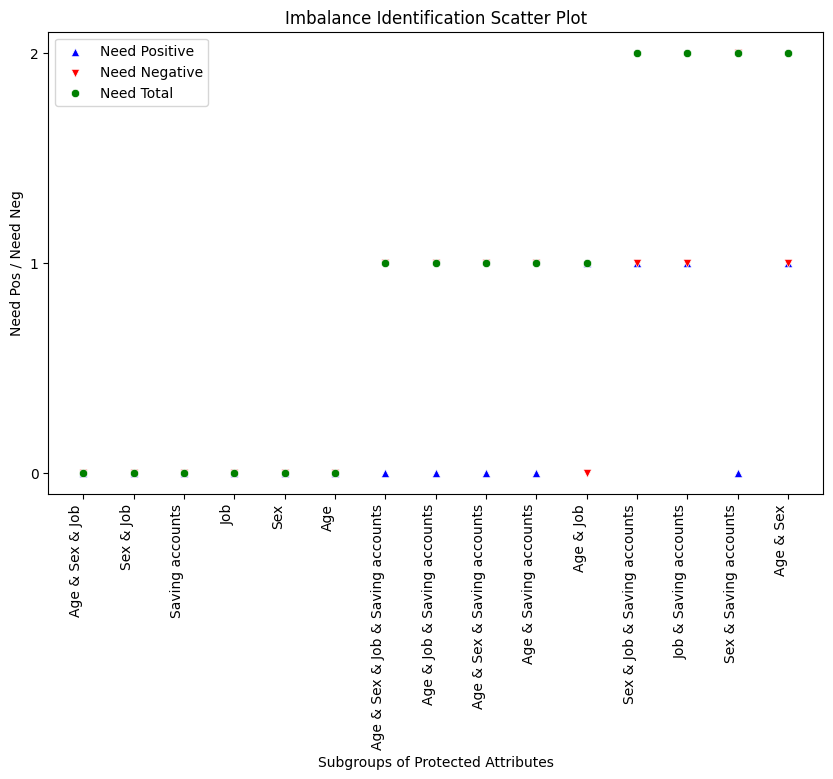

K:  80 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


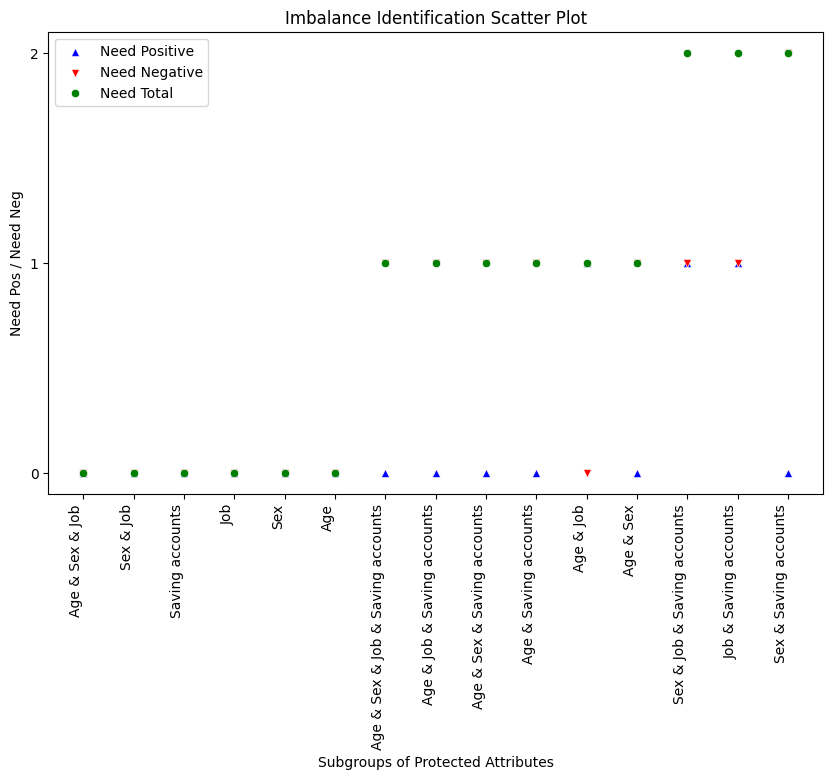

K:  90 imbalance threshold: 0.1
Subgroup with most required total updates is:  Sex & Job & Saving accounts


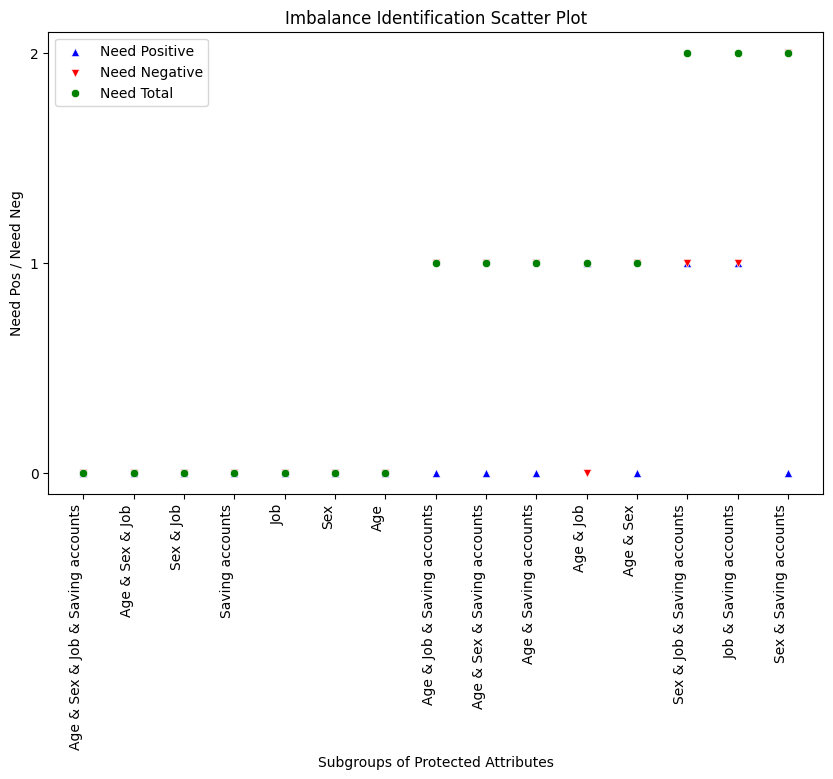

imbalance threshold:  0.1 K: 30
Subgroup with most required total updates is:  Sex & Job & Saving accounts


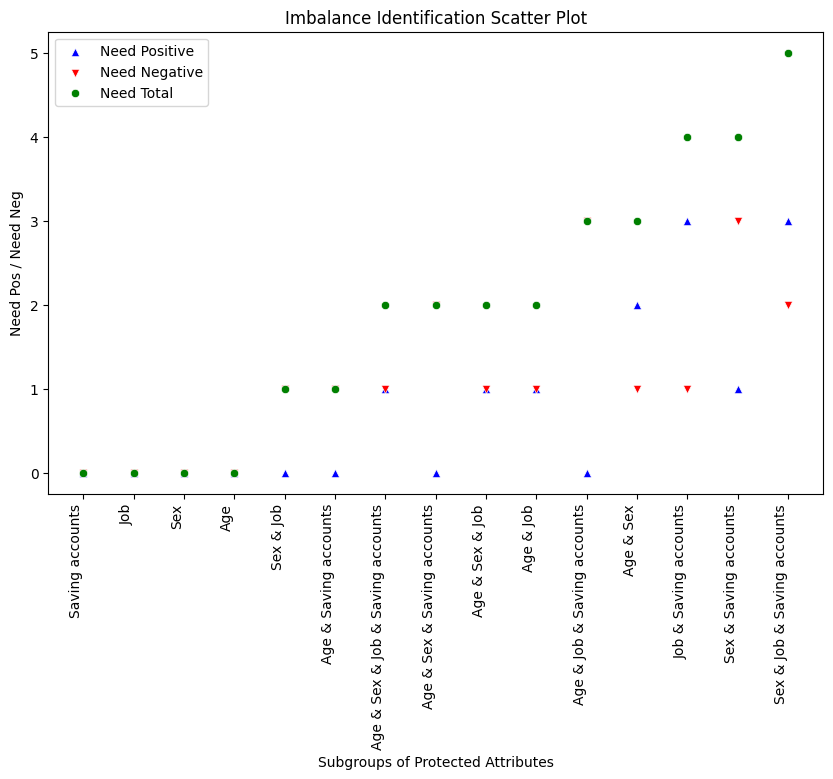

imbalance threshold:  0.2 K: 30
Subgroup with most required total updates is:  Job & Saving accounts


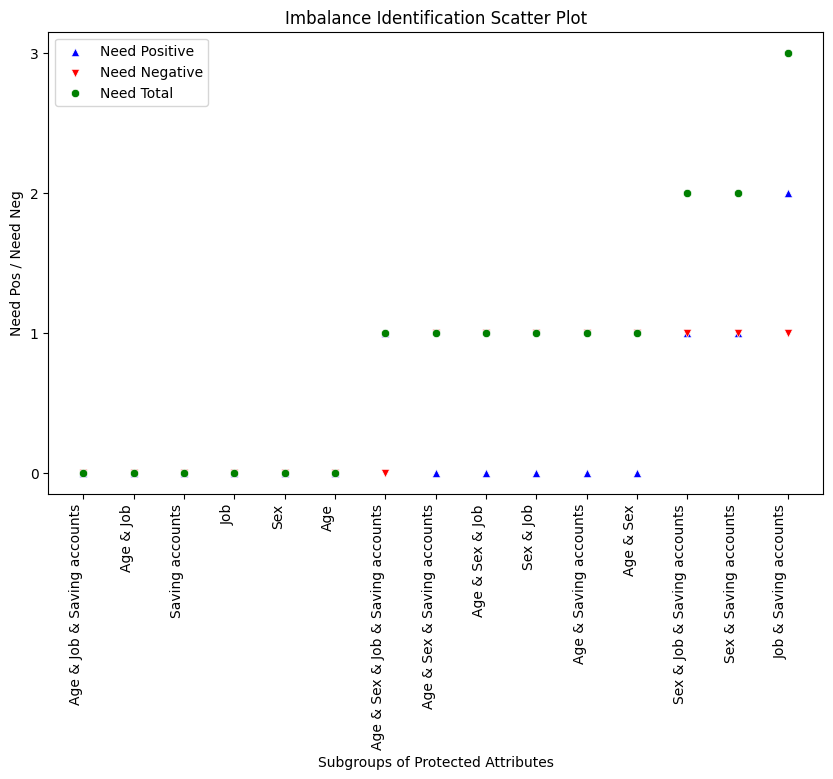

imbalance threshold:  0.30000000000000004 K: 30
Subgroup with most required total updates is:  Age & Sex & Job


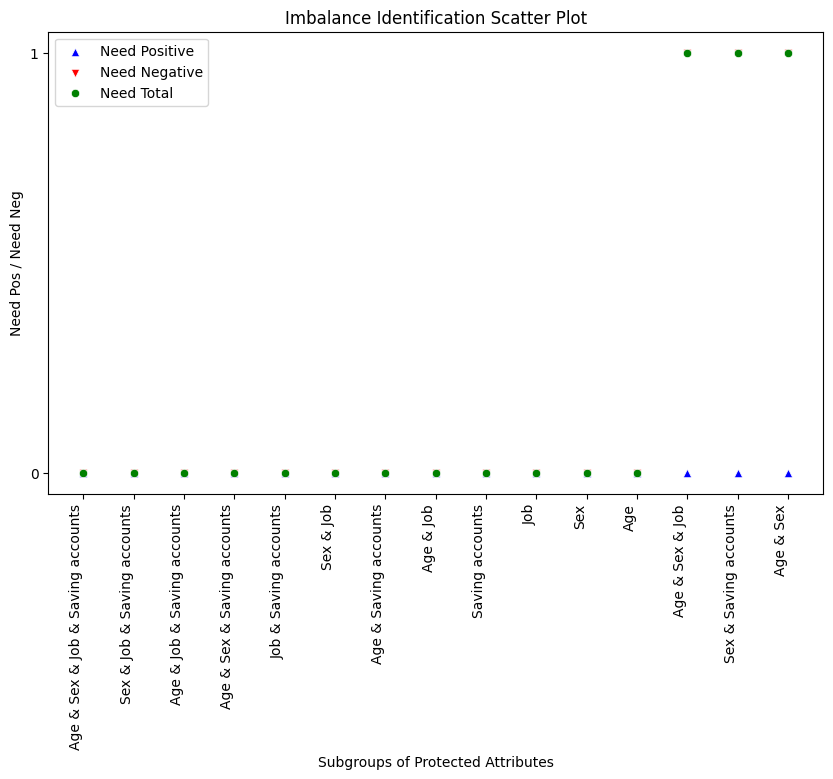

imbalance threshold:  0.4 K: 30
Subgroup with most required total updates is:  Age & Sex & Job


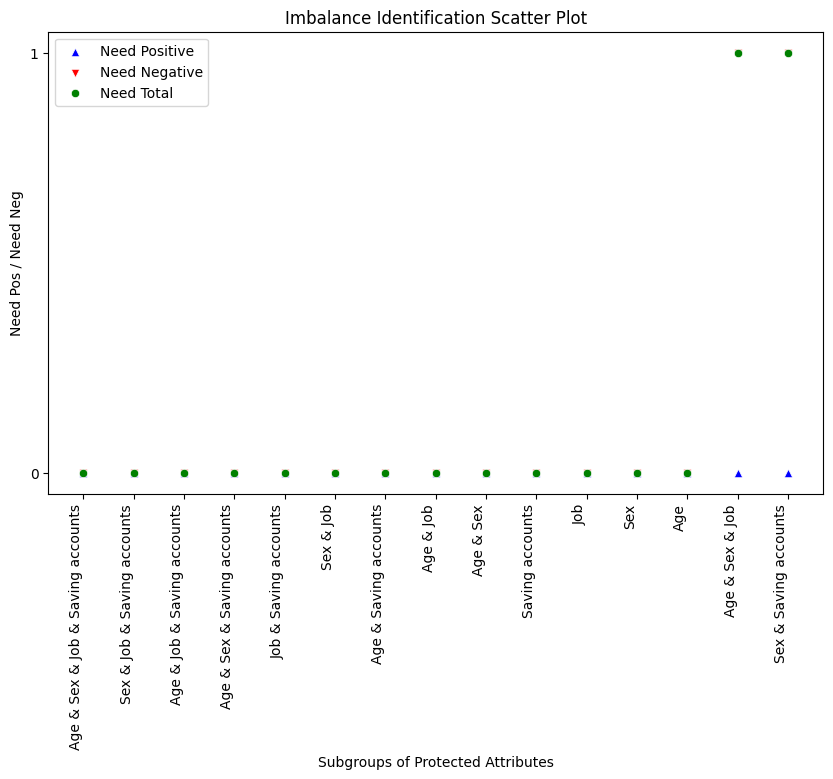

imbalance threshold:  0.5 K: 30
Subgroup with most required total updates is:  Age & Sex & Job


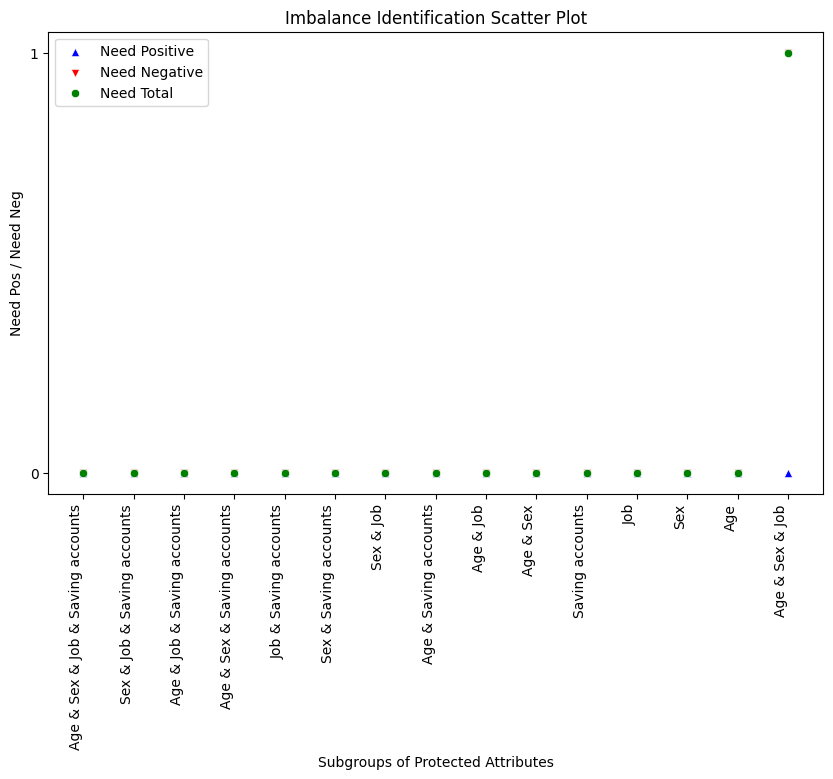

imbalance threshold:  0.6 K: 30
Subgroup with most required total updates is:  Age & Sex & Job


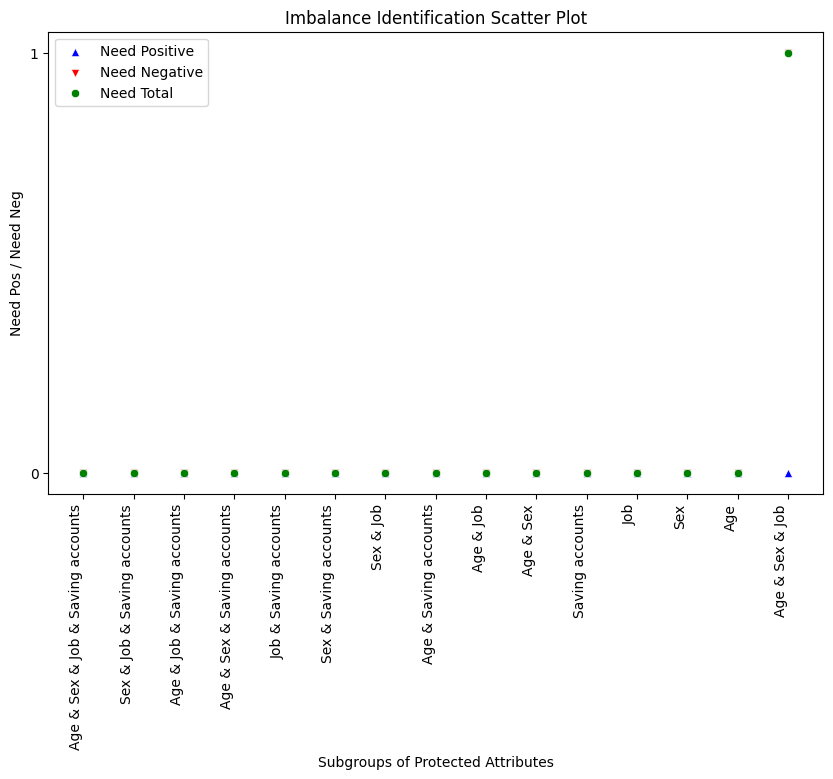

imbalance threshold:  0.7000000000000001 K: 30
Subgroup with most required total updates is:  Age & Sex & Job


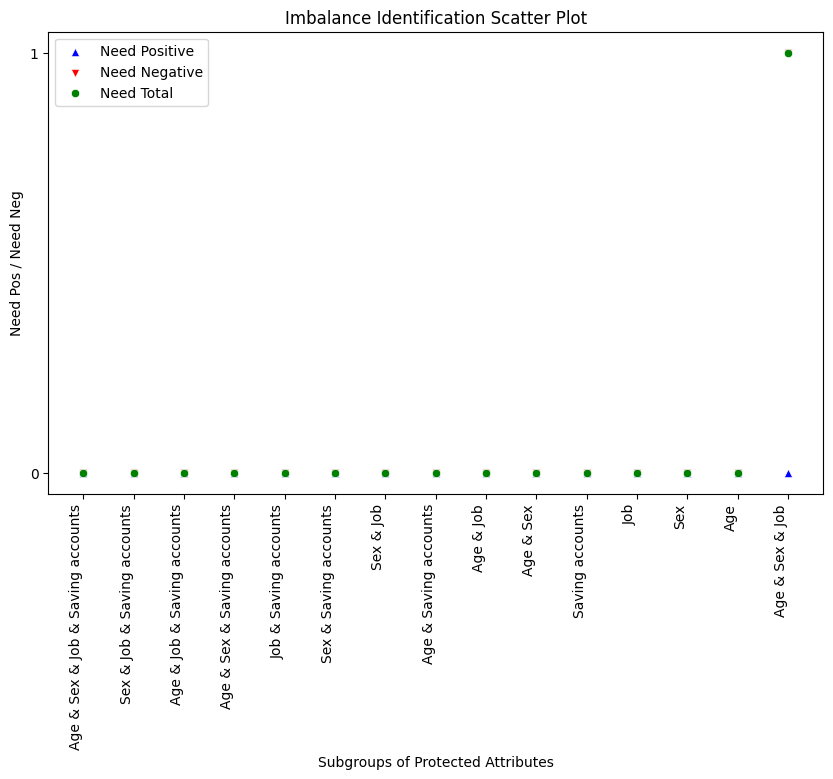

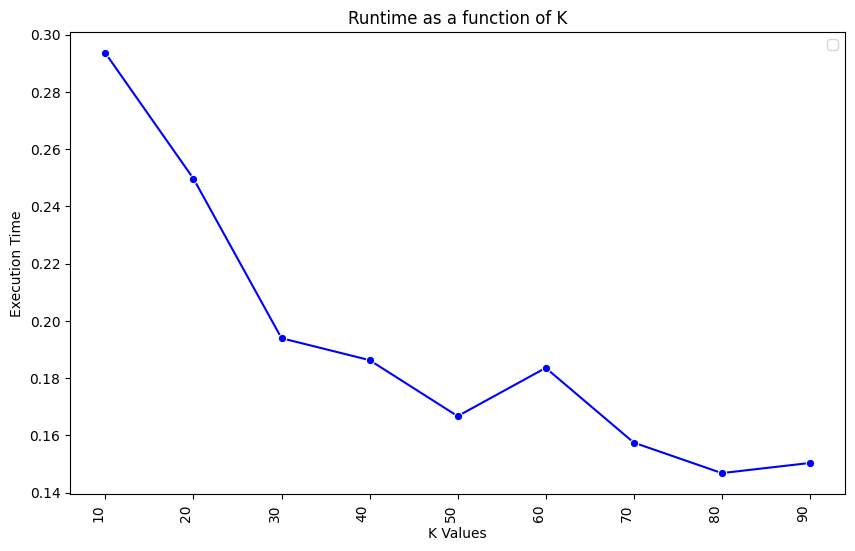

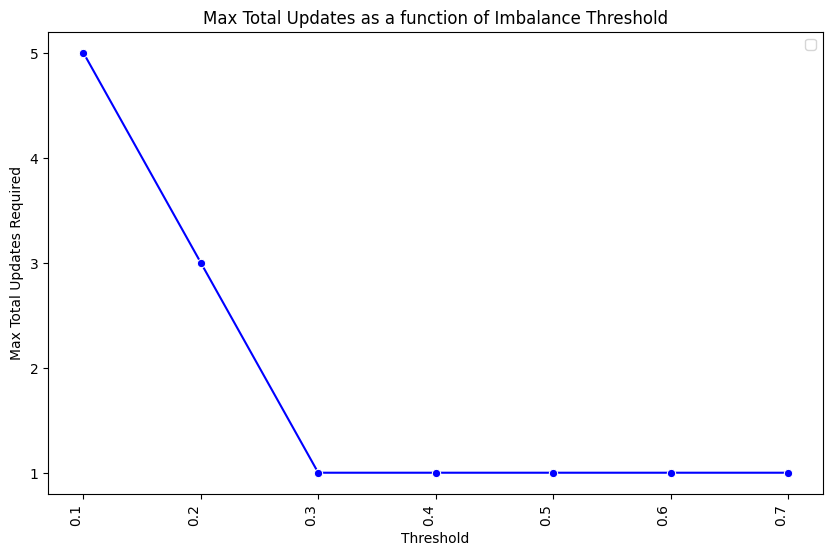

In [131]:
data_gcd = pd.read_csv('german_credit_data.csv')

# class is 1/2 instead of 0/1
data_gcd['class'] = data_gcd['class'] - 1

columns_gcd = ['Age', 'Sex', 'Job', 'Saving accounts']
gcd_y = 'class'
X_gcd = pd.DataFrame(data_gcd)

run_tests(X_gcd, columns_gcd, gcd_y)


### COMPAS Dataset


K:  10 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender & native-country


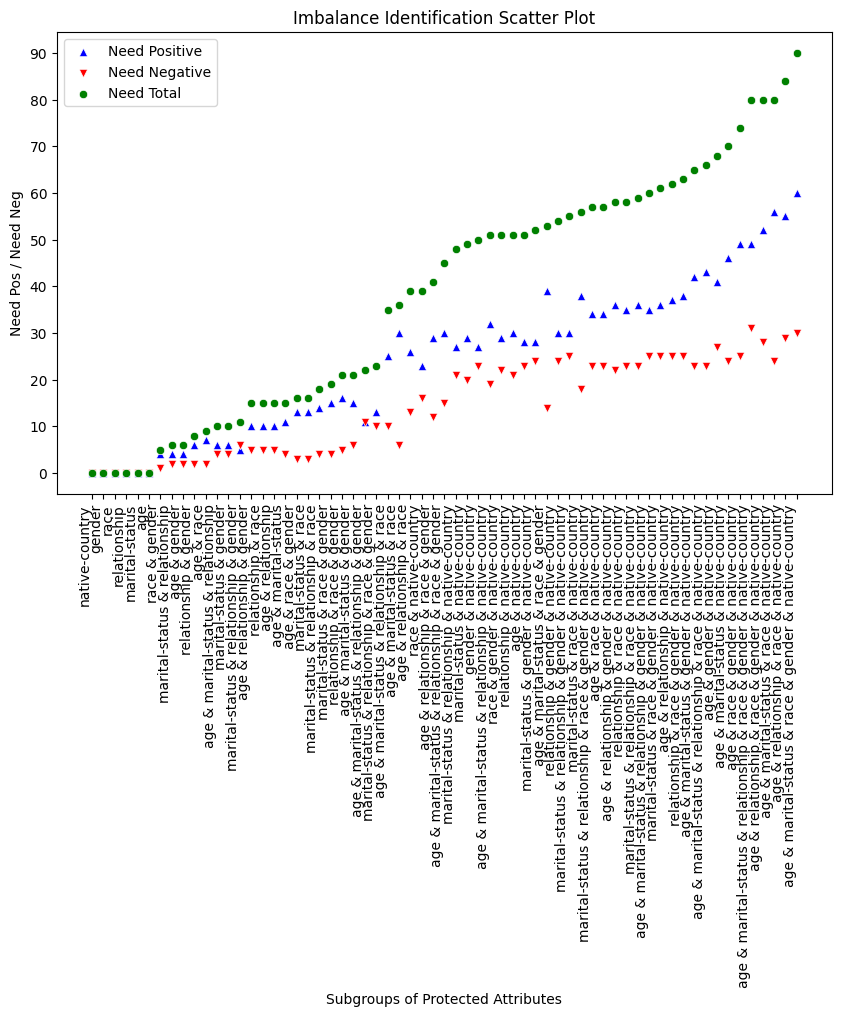

K:  20 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender & native-country


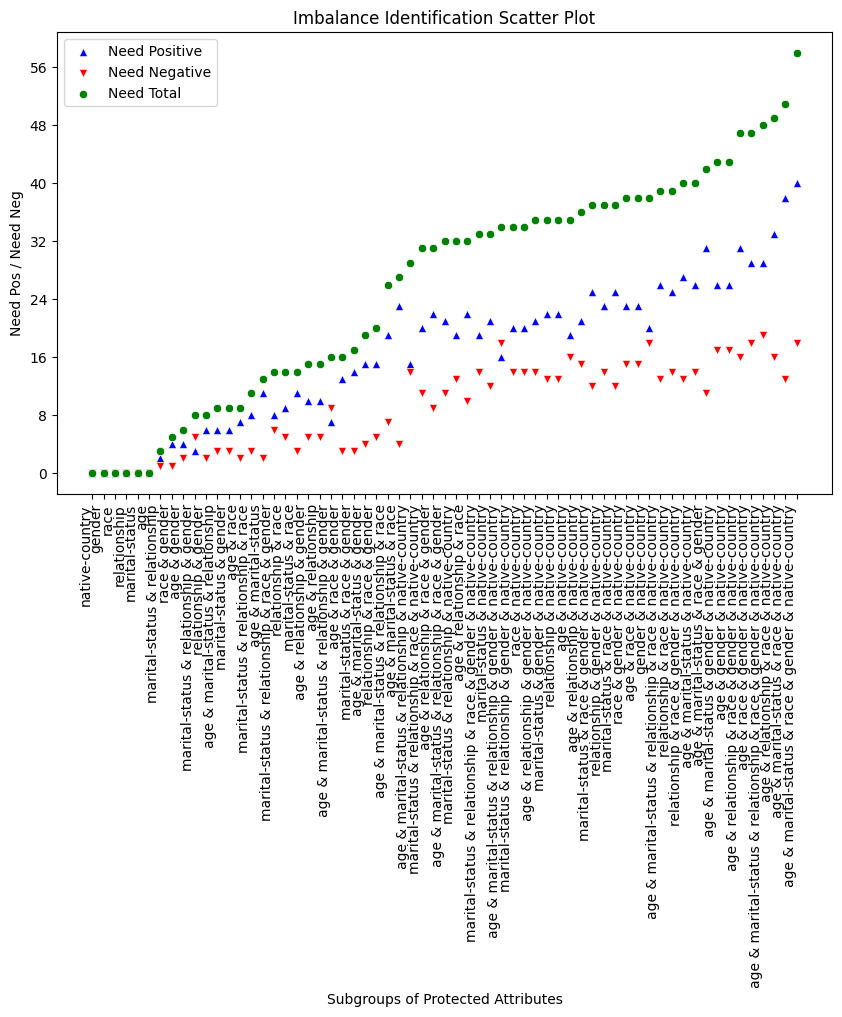

K:  30 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender & native-country


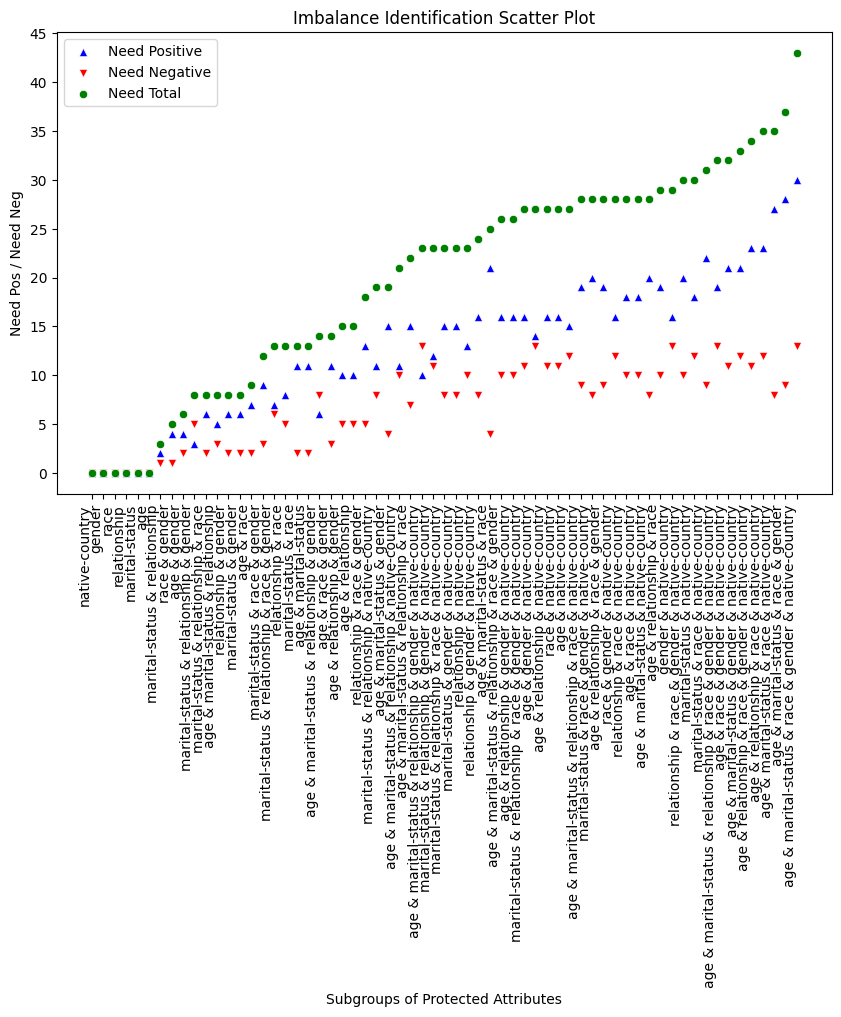

K:  40 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender & native-country


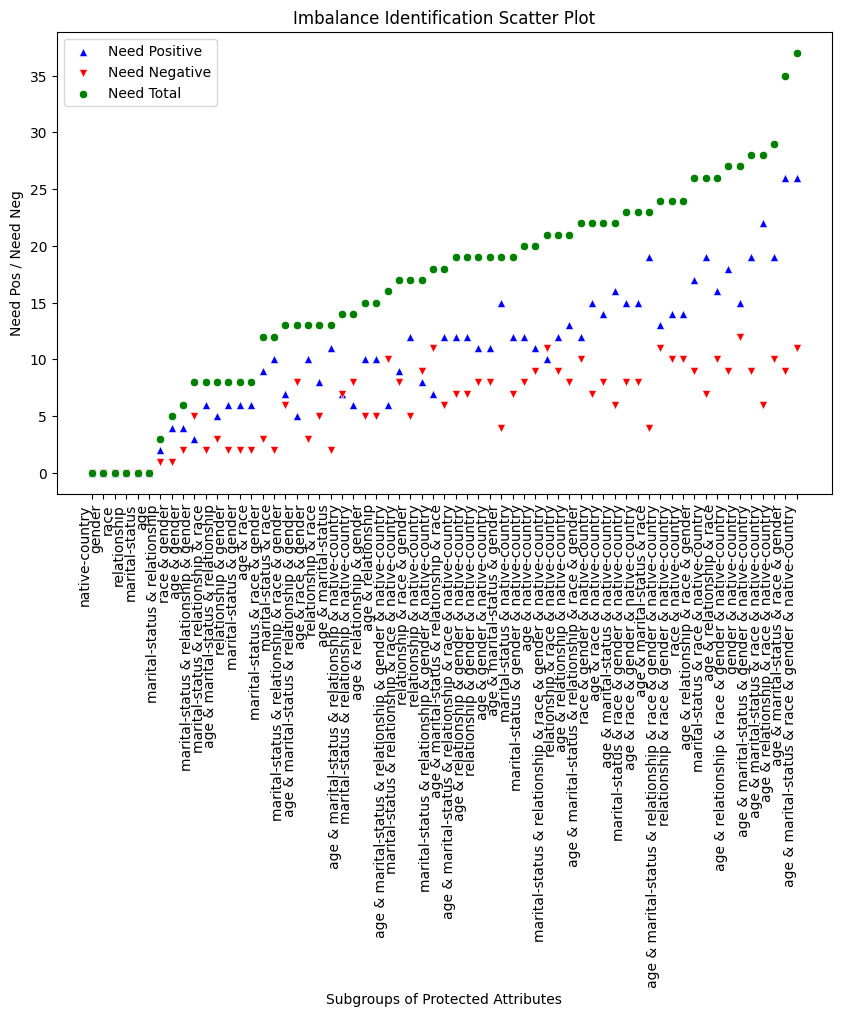

K:  50 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender


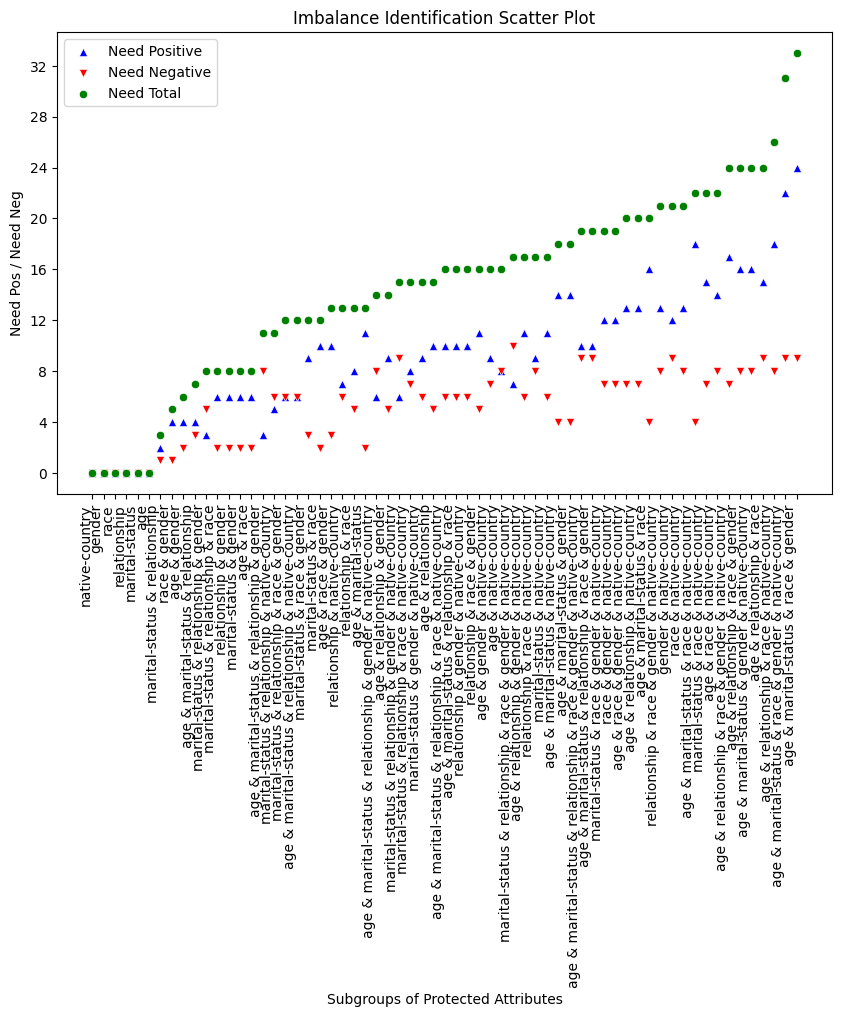

K:  60 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender


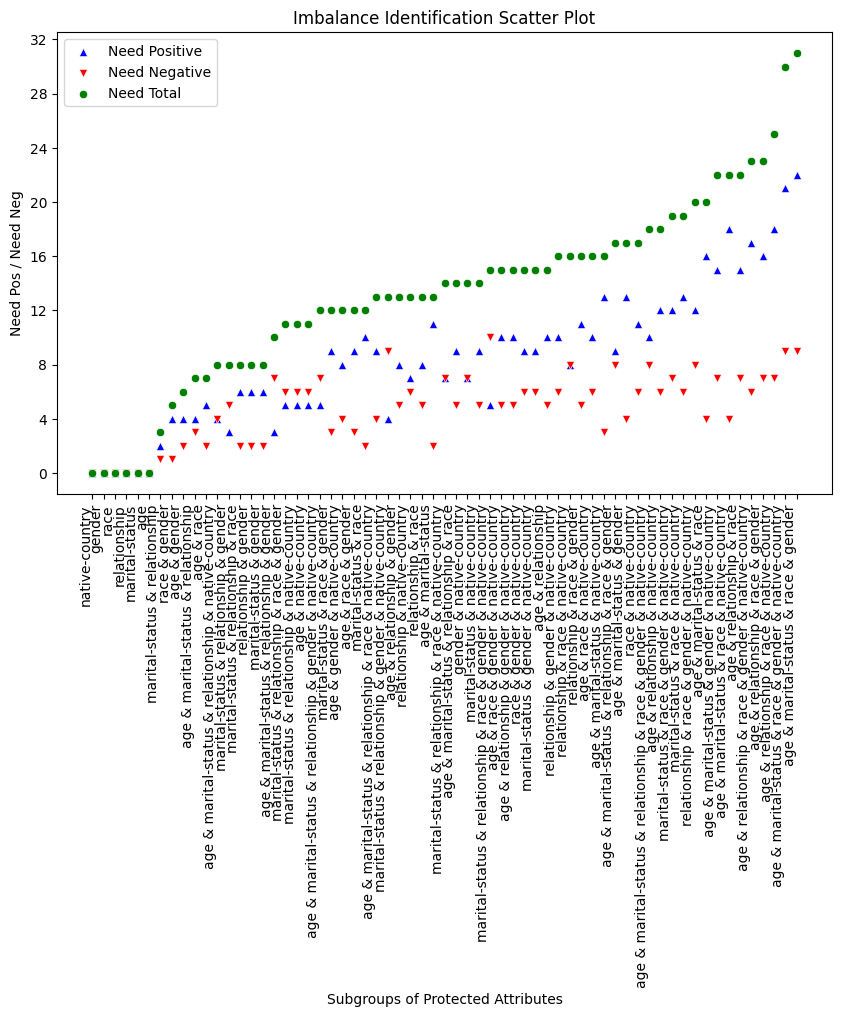

K:  70 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender & native-country


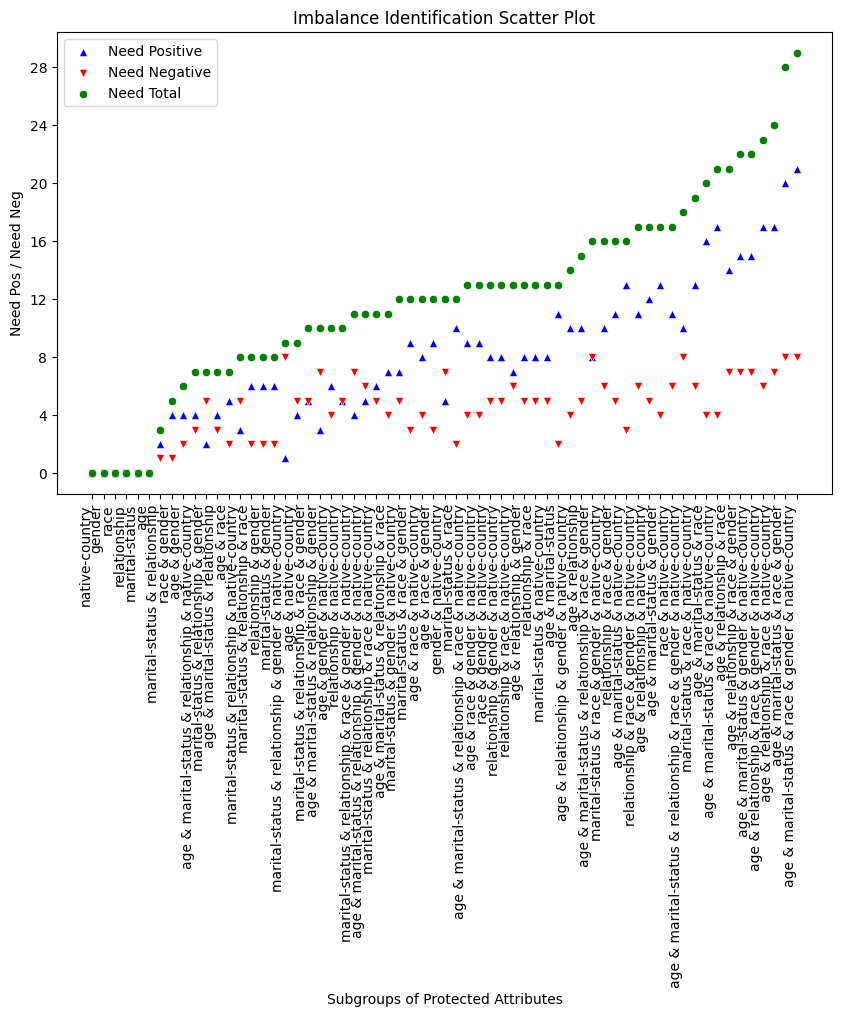

K:  80 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender


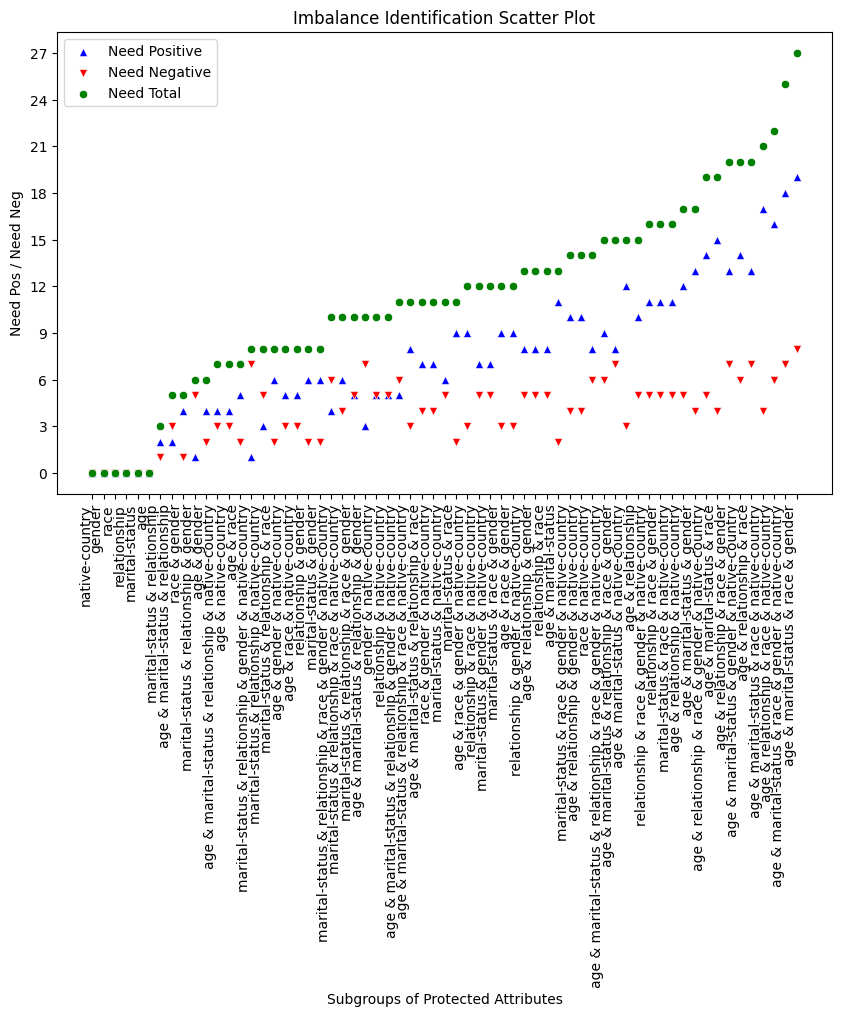

K:  90 imbalance threshold: 0.1
Subgroup with most required total updates is:  age & marital-status & race & gender


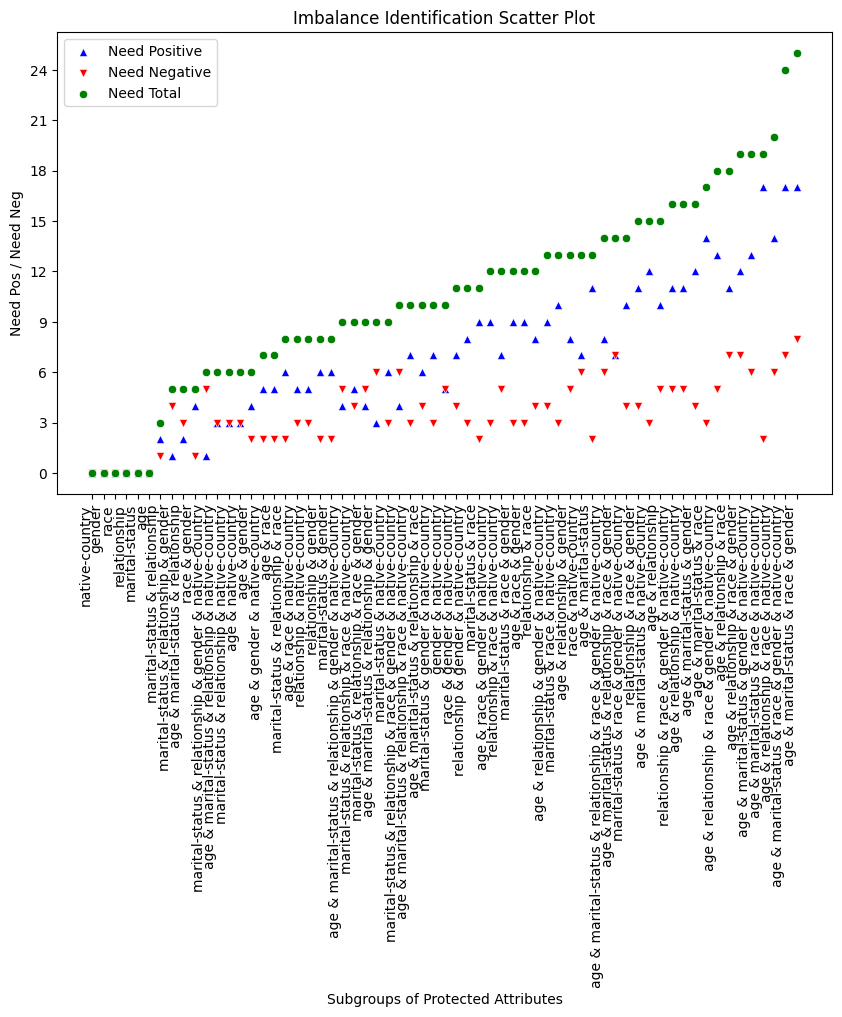

imbalance threshold:  0.1 K: 30
Subgroup with most required total updates is:  age & marital-status & race & gender & native-country


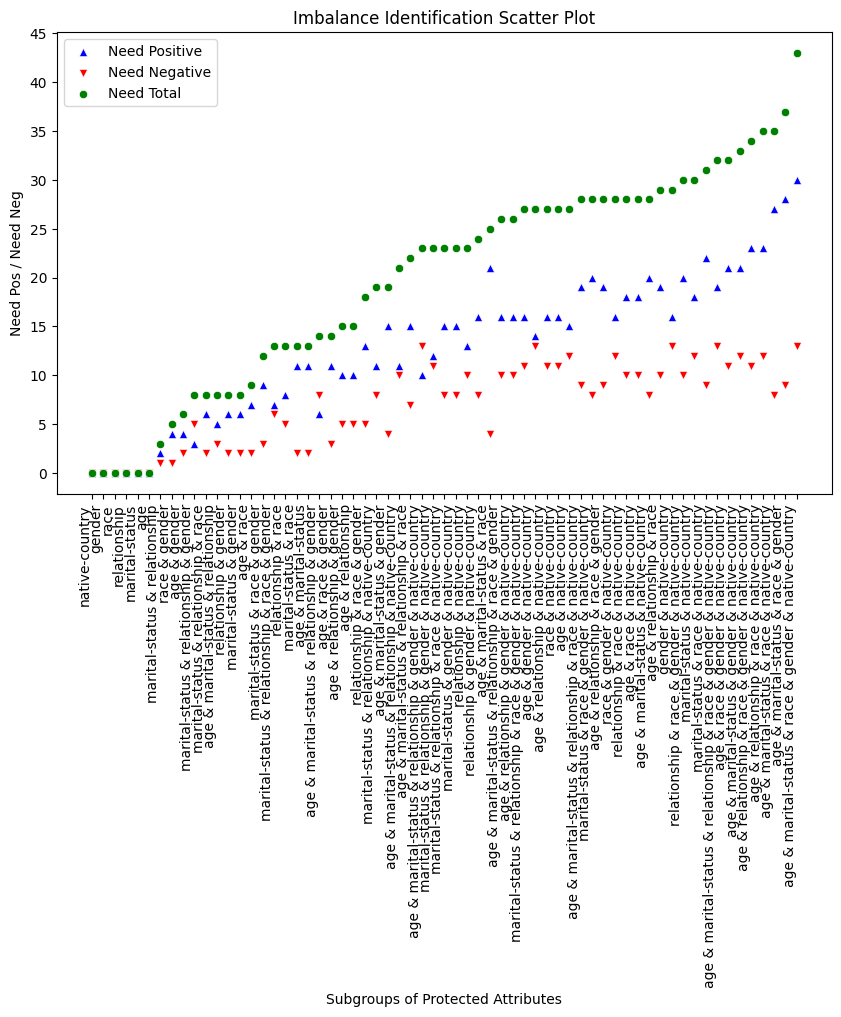

imbalance threshold:  0.2 K: 30
Subgroup with most required total updates is:  age & marital-status & race & native-country


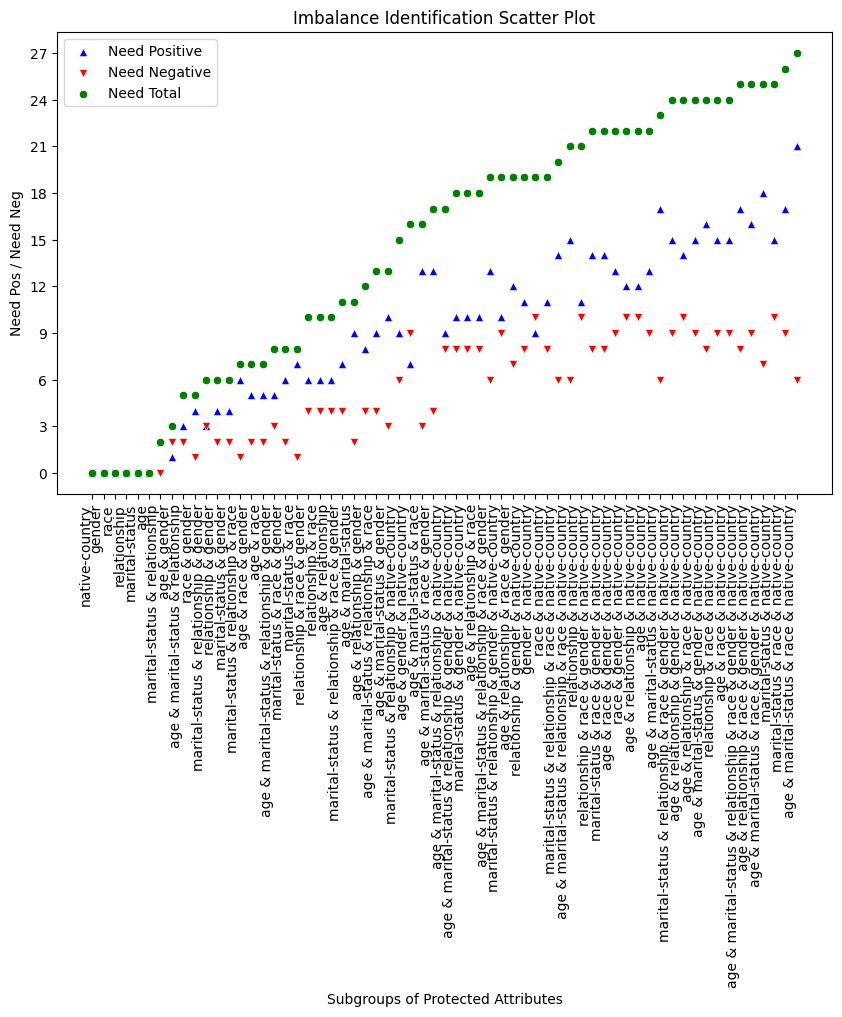

imbalance threshold:  0.30000000000000004 K: 30
Subgroup with most required total updates is:  marital-status & relationship & race & gender & native-country


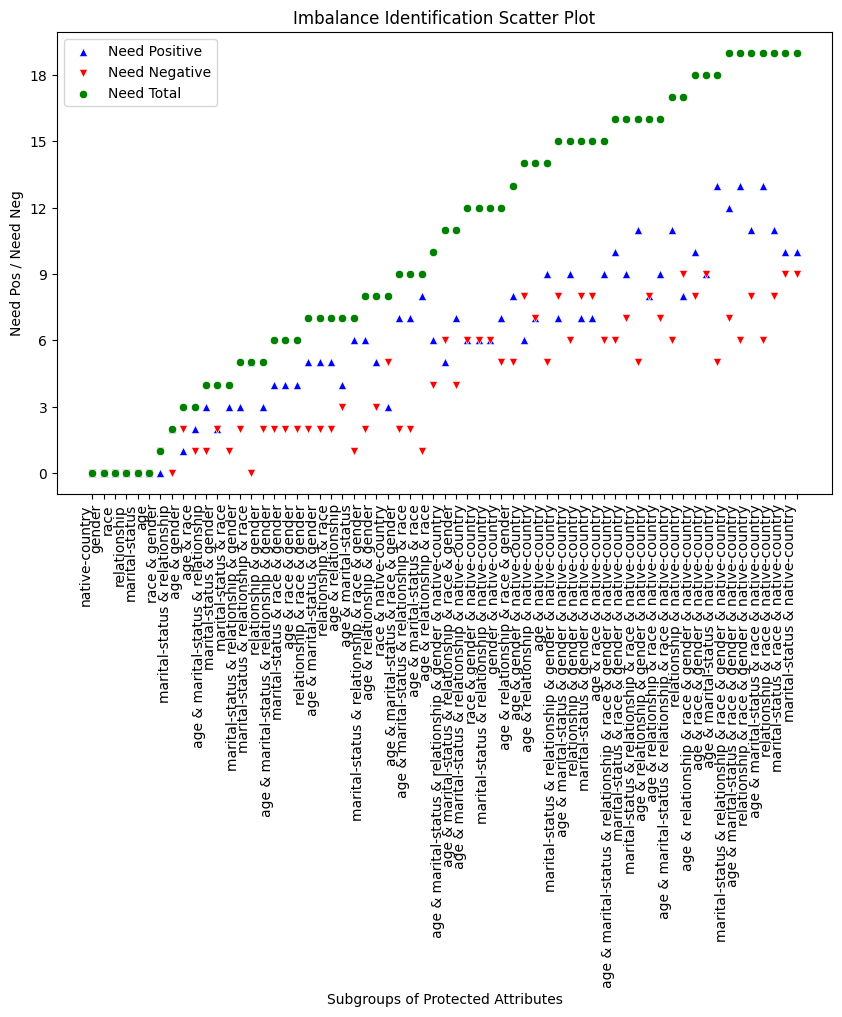

imbalance threshold:  0.4 K: 30
Subgroup with most required total updates is:  marital-status & relationship & race & gender & native-country


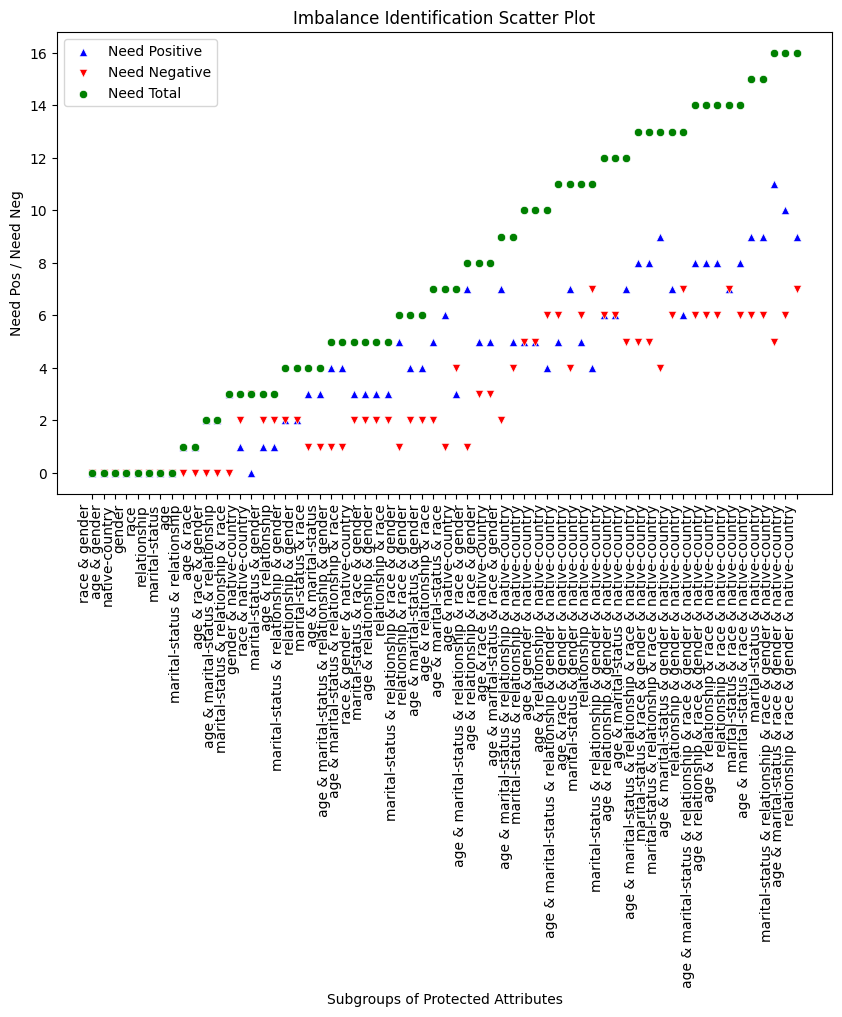

imbalance threshold:  0.5 K: 30
Subgroup with most required total updates is:  age & marital-status & relationship & race & gender & native-country


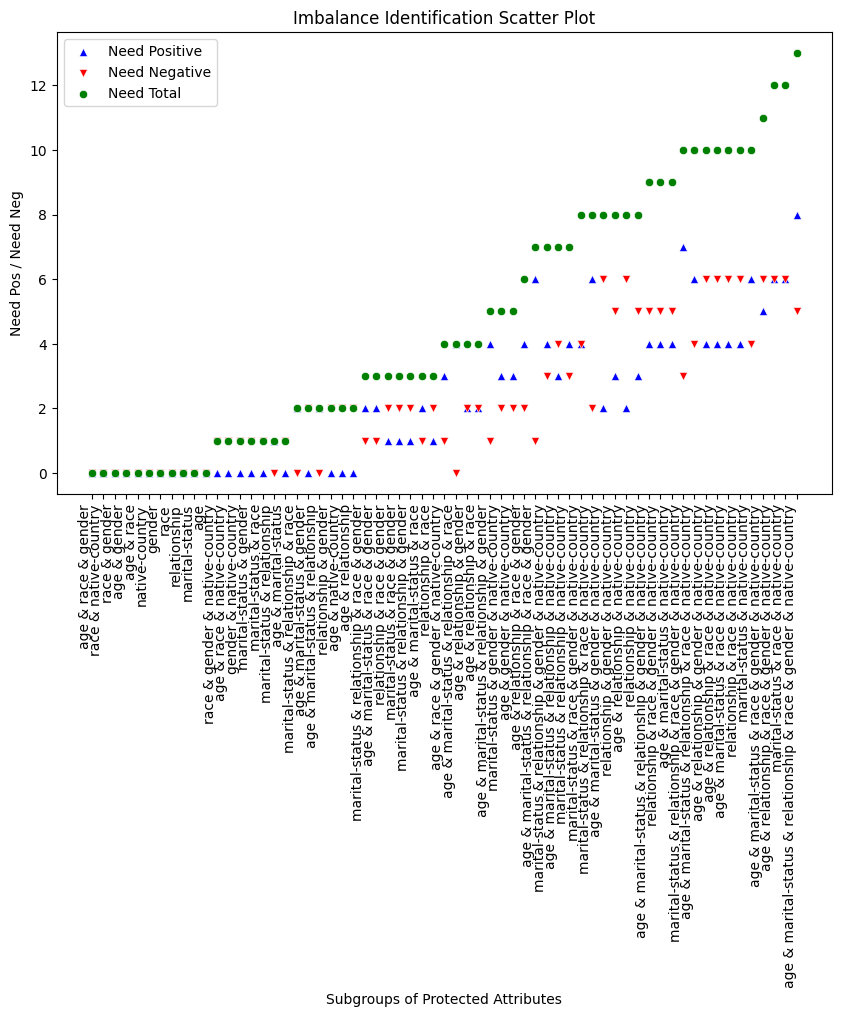

imbalance threshold:  0.6 K: 30
Subgroup with most required total updates is:  age & marital-status & relationship & race & gender & native-country


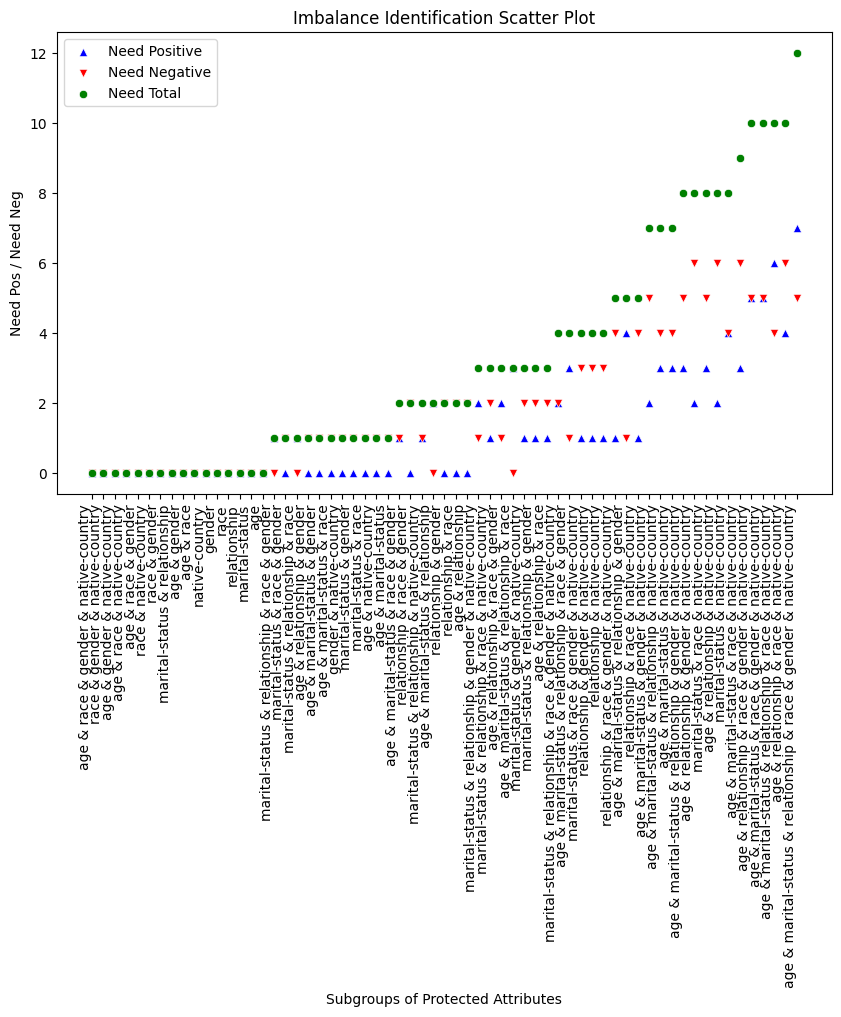

imbalance threshold:  0.7000000000000001 K: 30
Subgroup with most required total updates is:  age & marital-status & relationship & race & gender & native-country


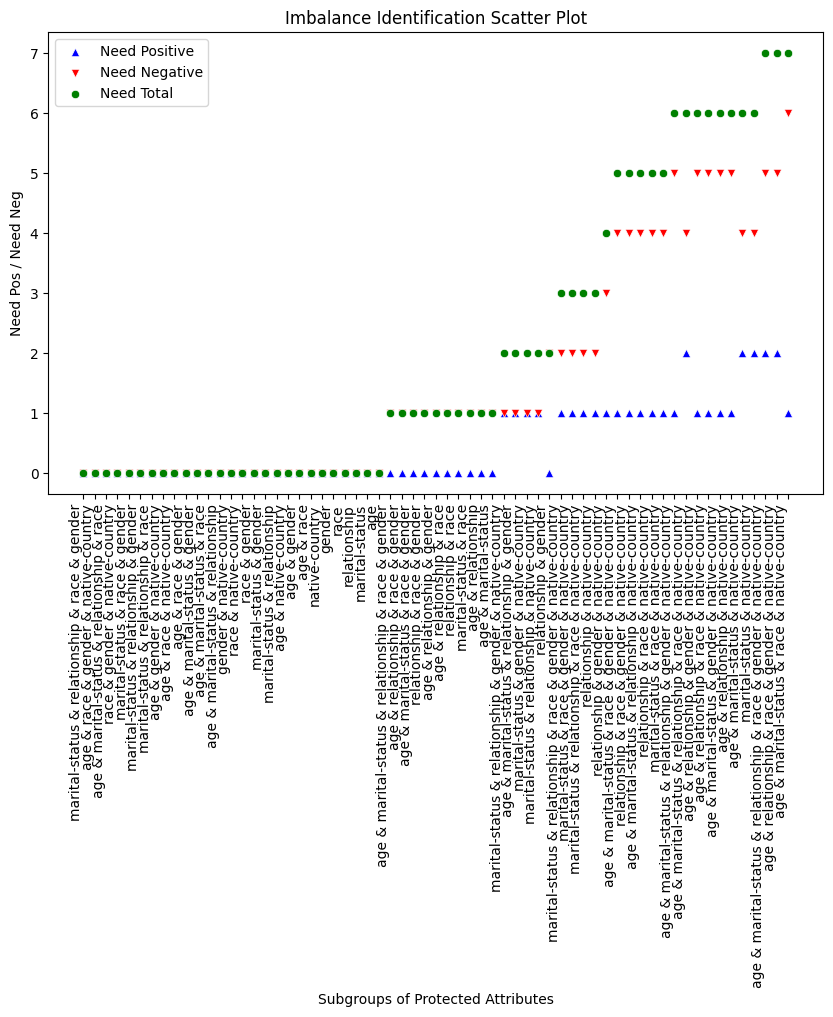

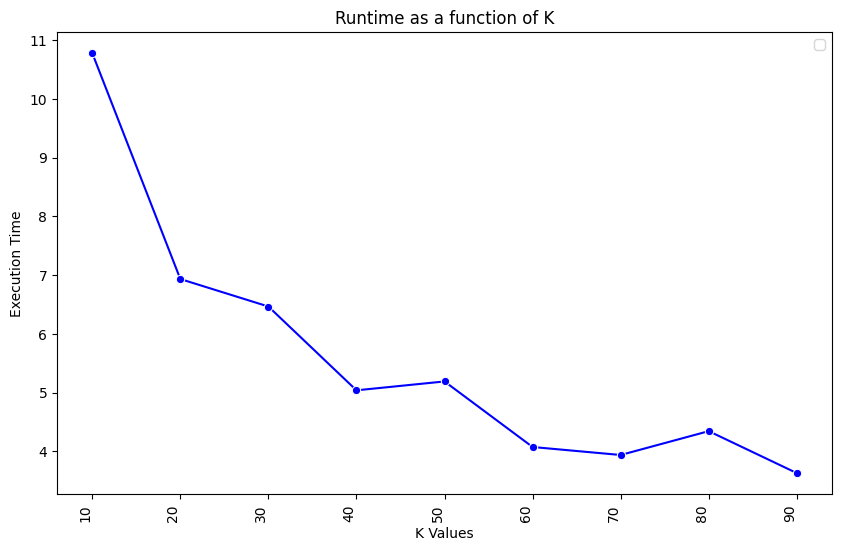

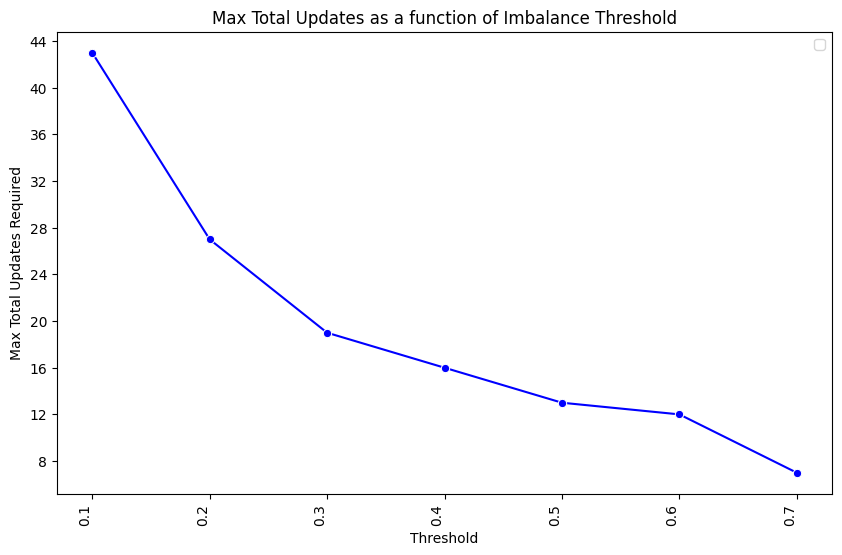

In [132]:
url = "https://raw.githubusercontent.com/niceIrene/remedy/main/datasets/CleanAdult_numerical_cat.csv"
X_compas = pd.read_csv(url)

# protected attributes
columns_compas = ['age', 'marital-status','relationship', 'race','gender', 'native-country']
columns_all = ['age', 'workclass','education', 'educational-num', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'capital-gain', 'capital-loss','hours-per-week', 'native-country']
compas_y = 'income'
run_tests(X_compas, columns_compas, compas_y)

### Stop, Question and Frisk


K:  10 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Sex & Race


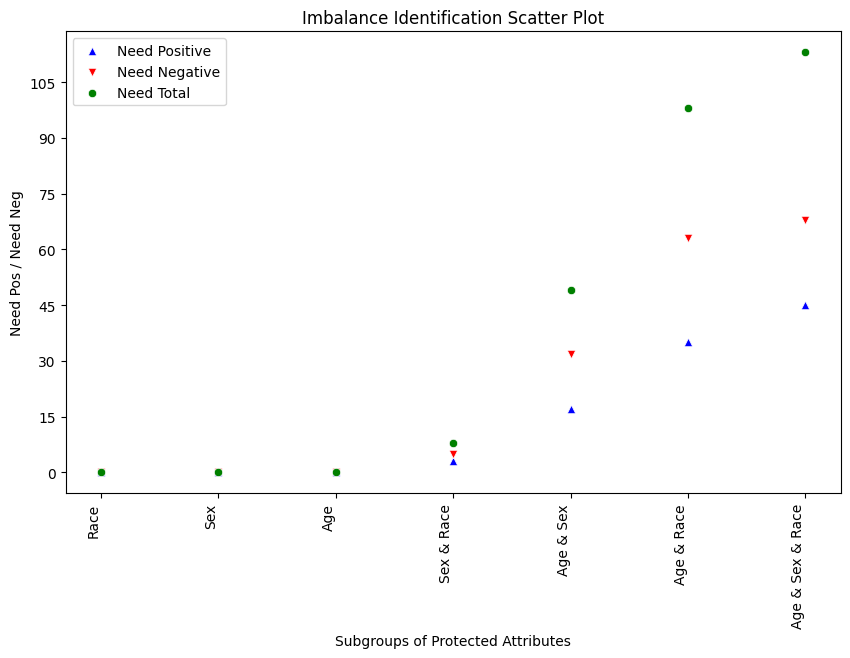

K:  20 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Sex & Race


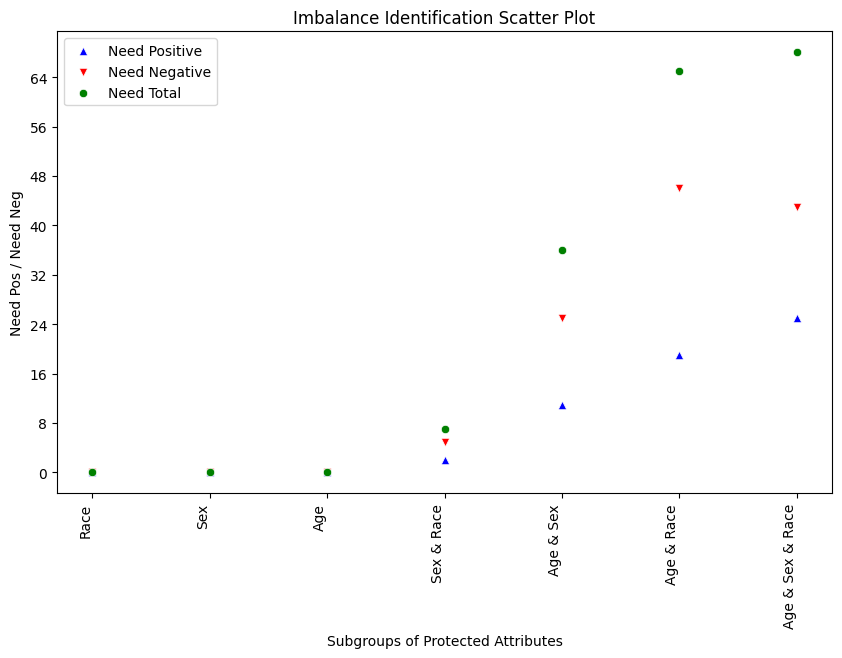

K:  30 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Race


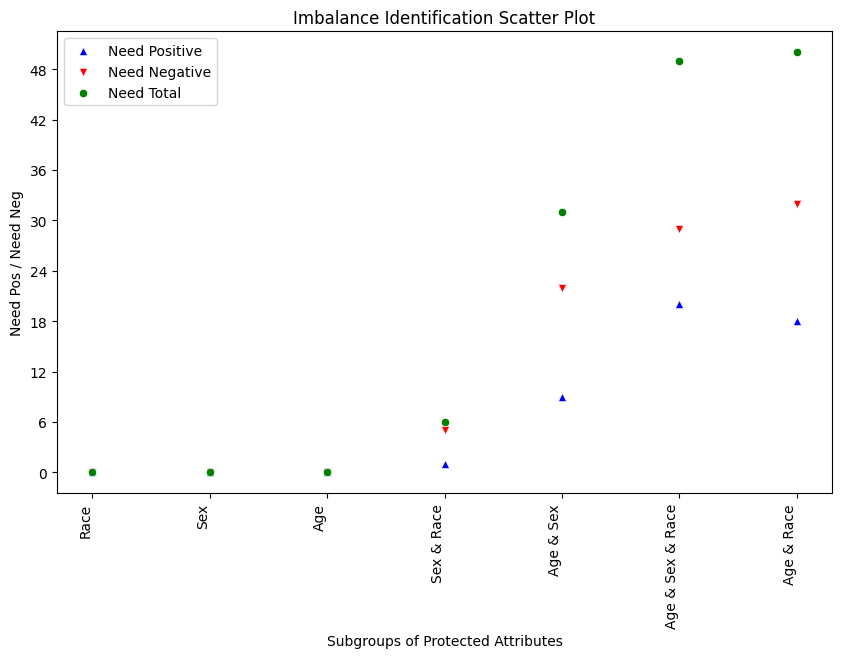

K:  40 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Race


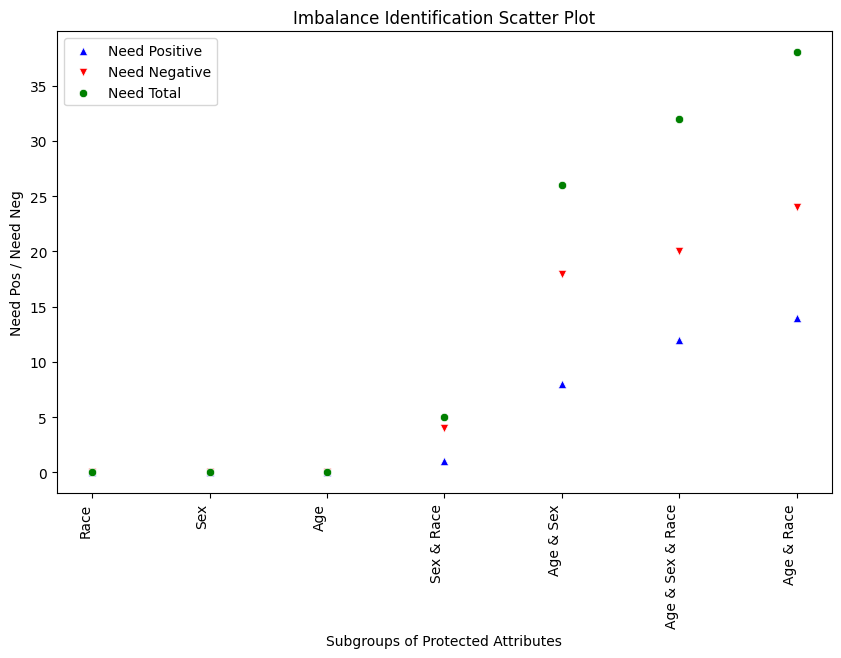

K:  50 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Race


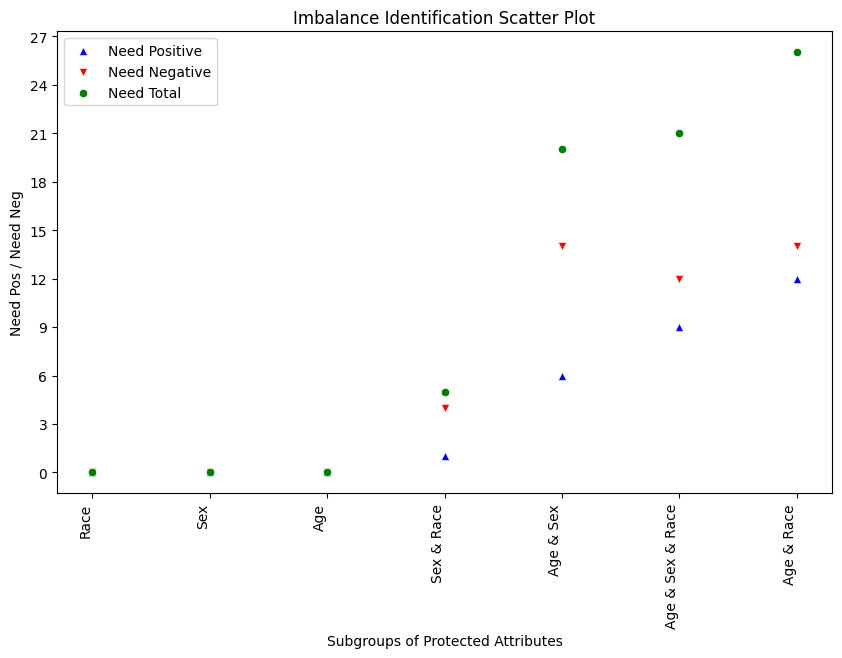

K:  60 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Race


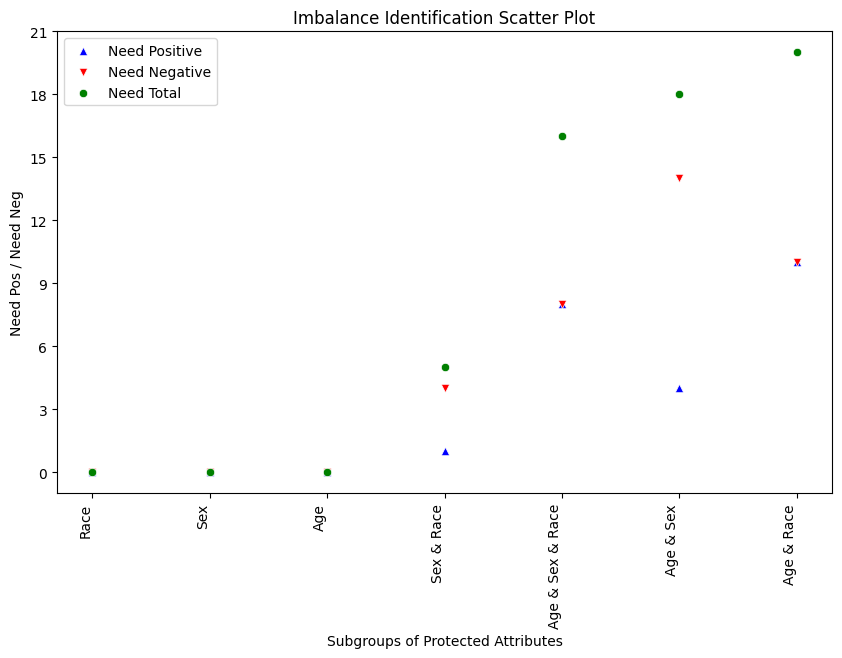

K:  70 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Race


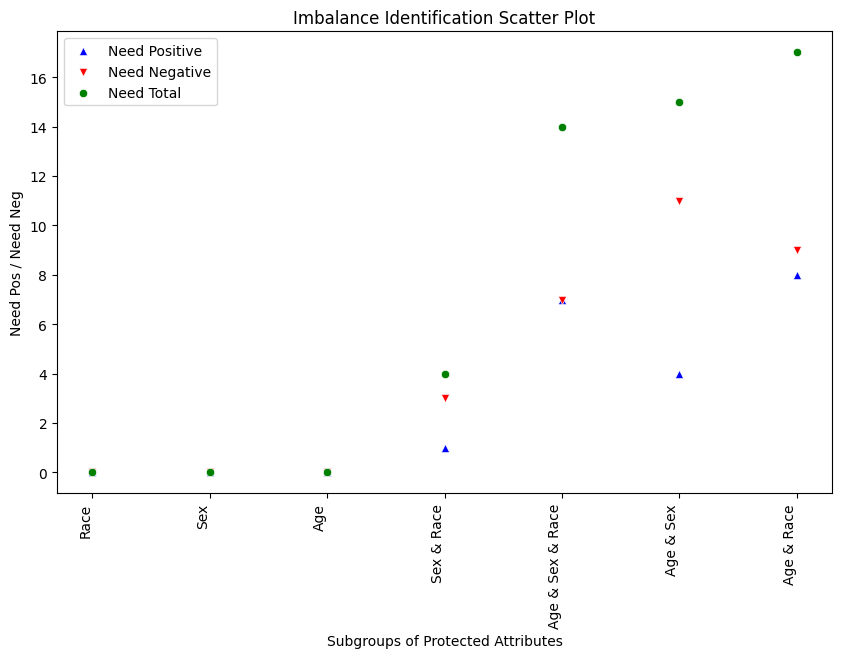

K:  80 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Race


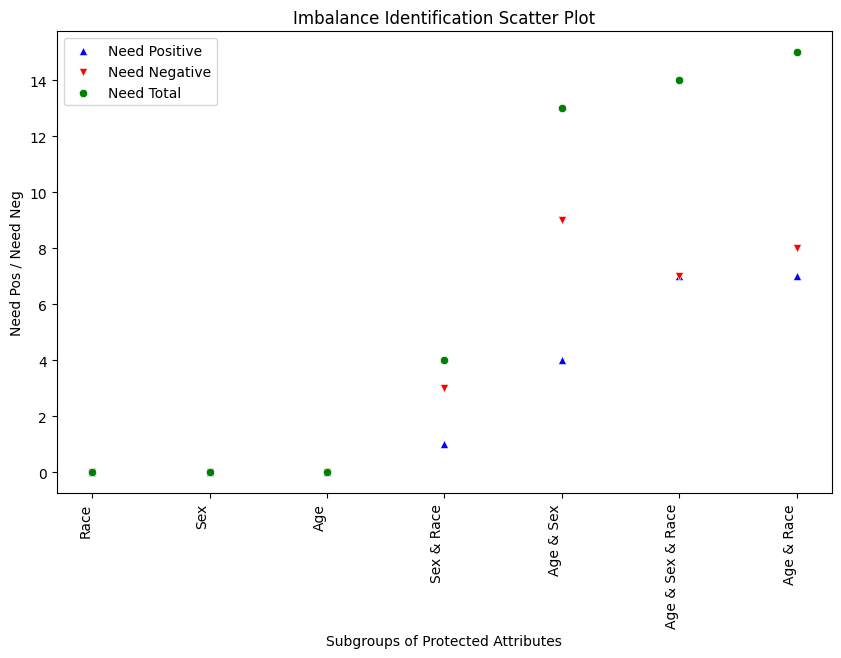

K:  90 imbalance threshold: 0.1
Subgroup with most required total updates is:  Age & Race


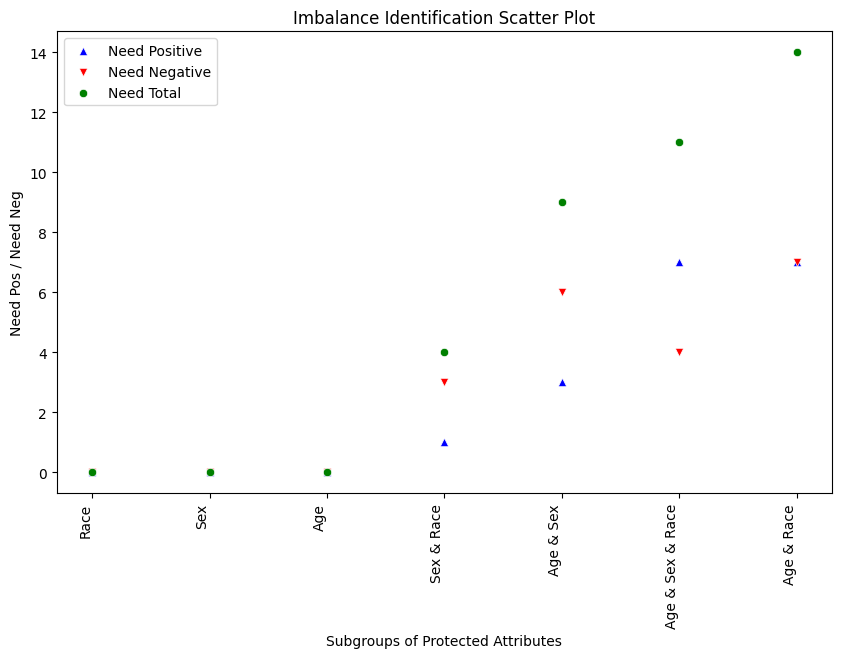

imbalance threshold:  0.1 K: 30
Subgroup with most required total updates is:  Age & Race


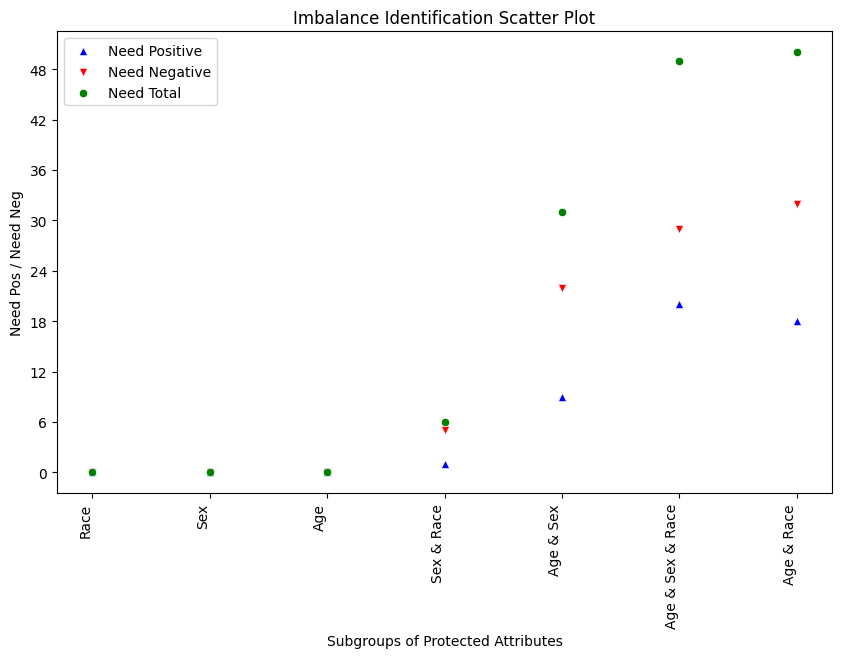

imbalance threshold:  0.2 K: 30
Subgroup with most required total updates is:  Age & Race


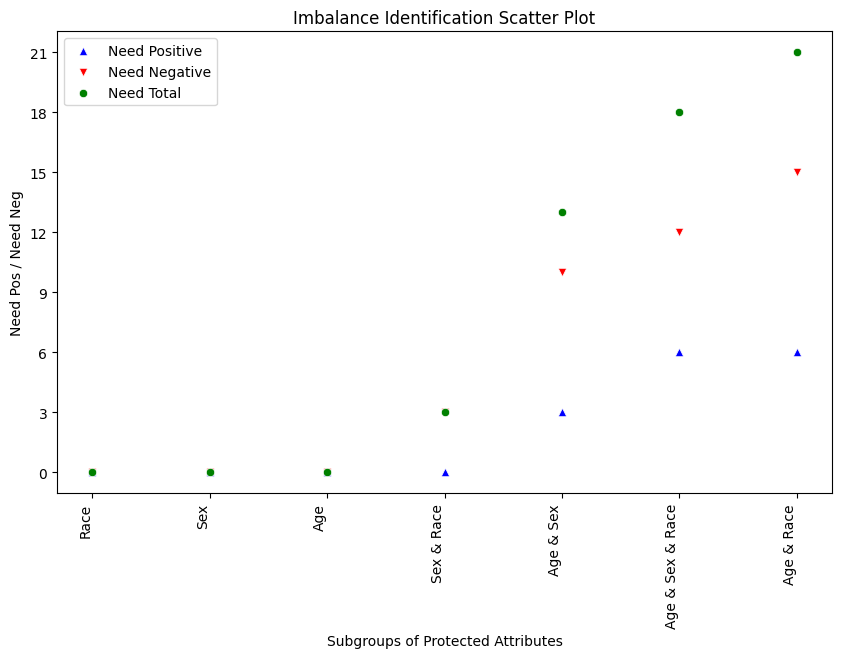

imbalance threshold:  0.30000000000000004 K: 30
Subgroup with most required total updates is:  Age & Race


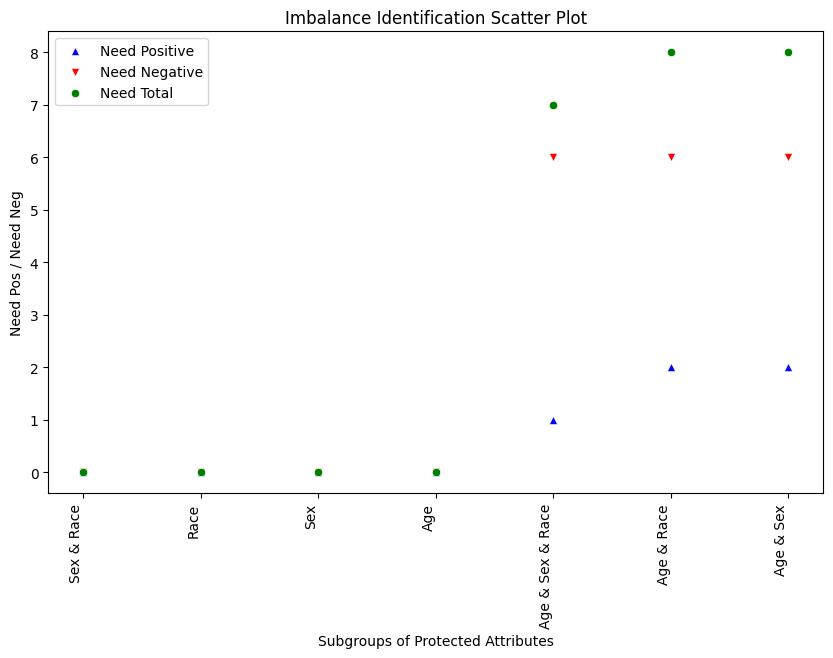

imbalance threshold:  0.4 K: 30
Subgroup with most required total updates is:  Age & Race


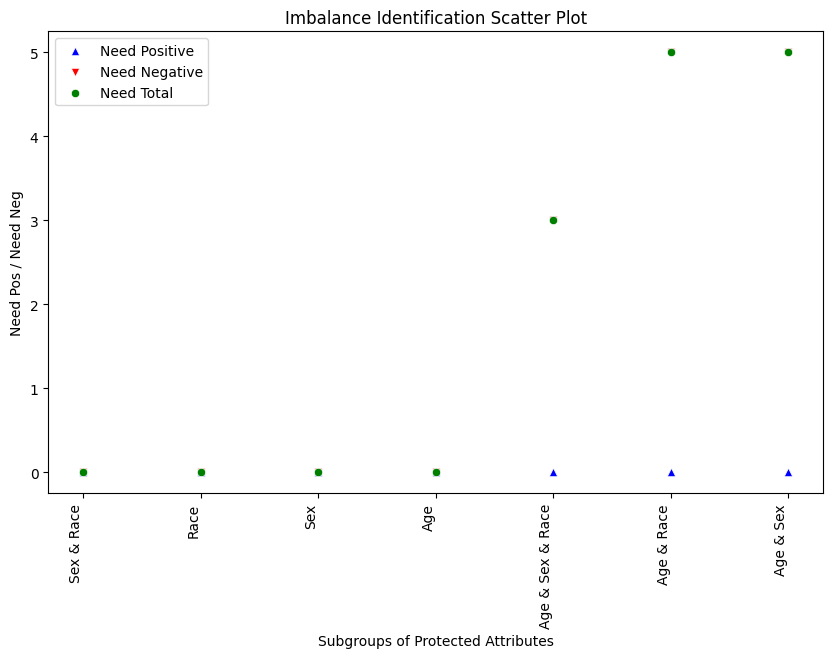

imbalance threshold:  0.5 K: 30
Subgroup with most required total updates is:  Age & Race


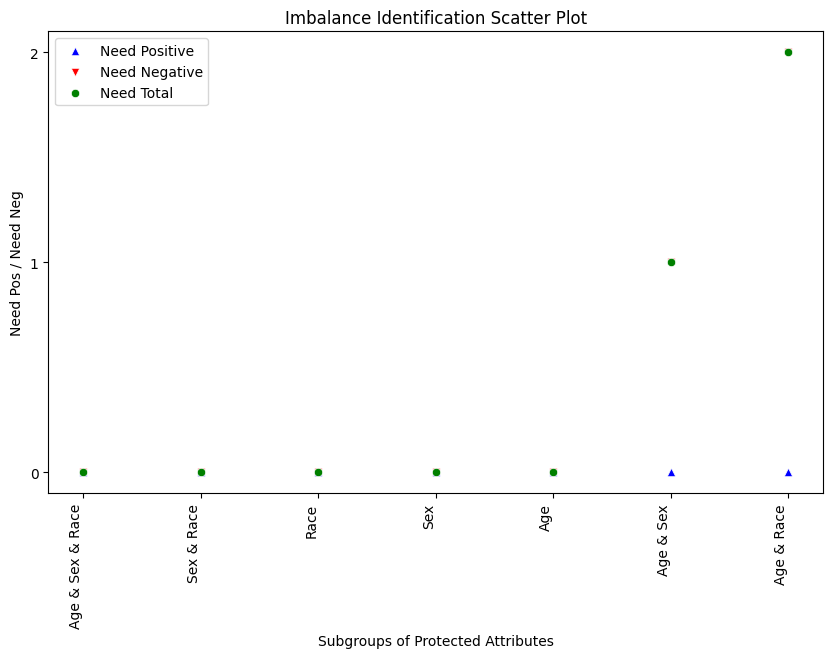

imbalance threshold:  0.6 K: 30
Subgroup with most required total updates is:  Age & Race


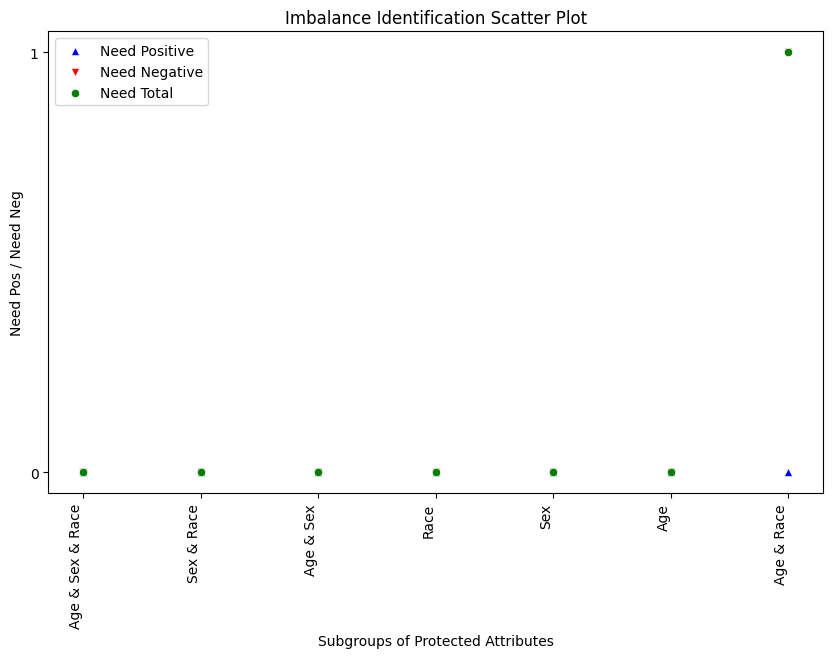

imbalance threshold:  0.7000000000000001 K: 30
Subgroup with most required total updates is:  Age & Race


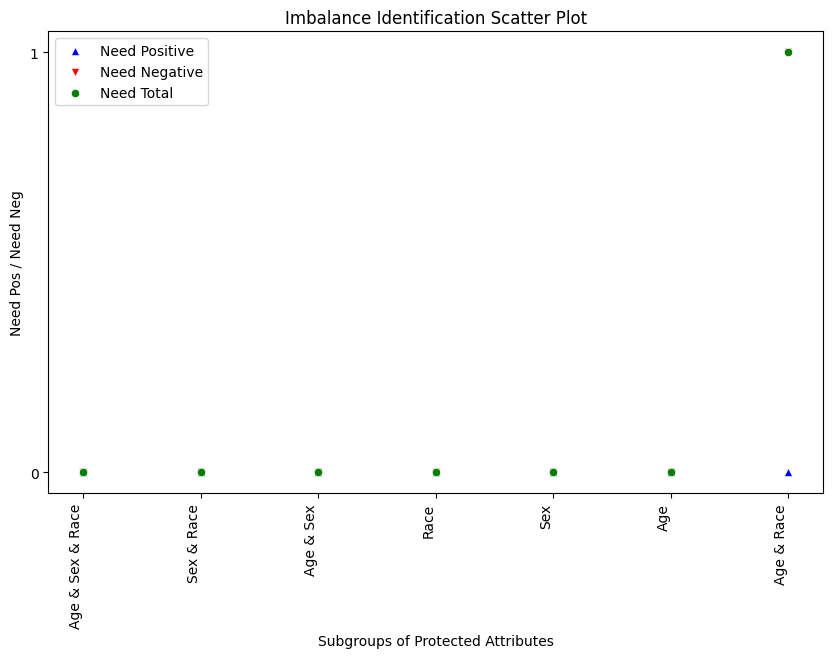

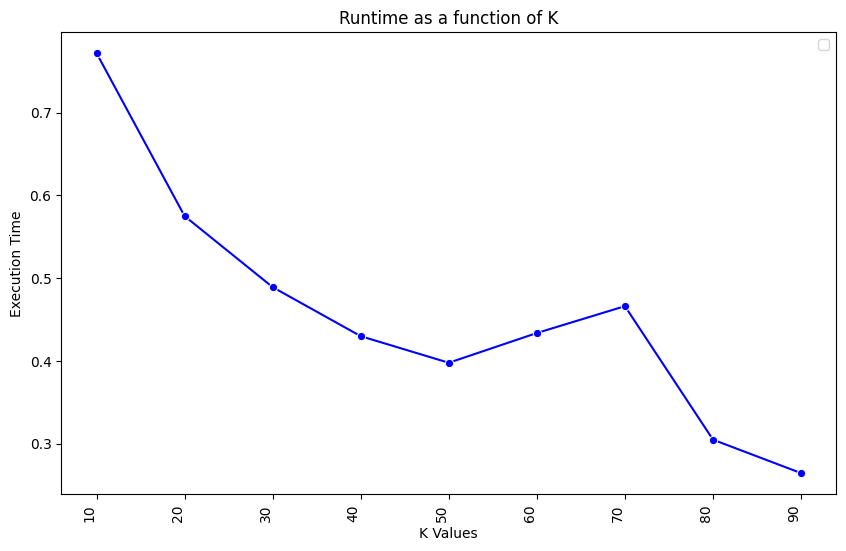

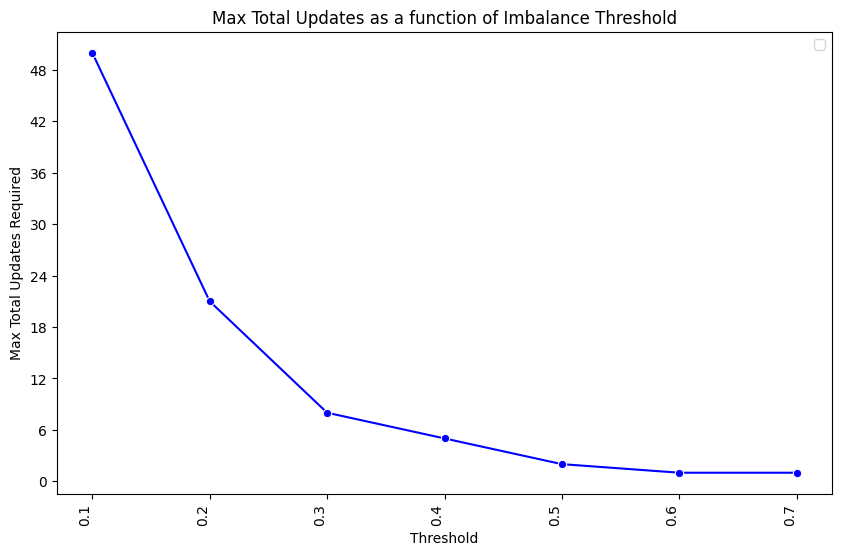

In [133]:
data_sqfd = pd.read_csv('SQFD - CY 2017.csv')

# SUSPECT_ARRESTED_FLAG is Y/N instead of 0/1
data_sqfd = data_sqfd.replace({"Y": 1, "N": 0})

columns_sqfd = ['Age', 'Sex', 'Race']

sqfd_y = 'SUSPECT_ARRESTED_FLAG'

X_sqfd = pd.DataFrame(data_sqfd)
run_tests(X_sqfd, columns_sqfd, sqfd_y)

### Default of credit card clients


K:  10 imbalance threshold: 0.1
Subgroup with most required total updates is:  X2 & X3 & X4 & X5


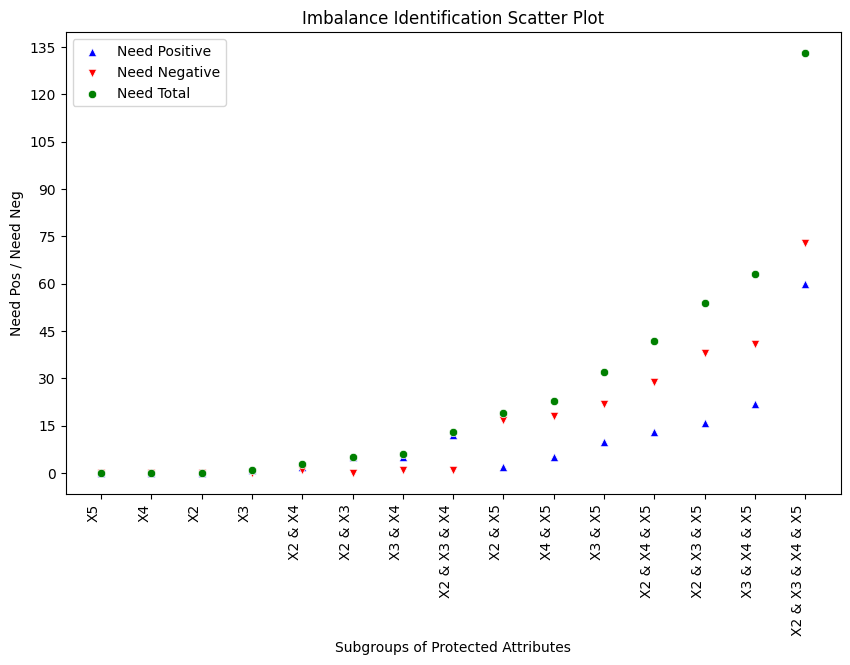

K:  20 imbalance threshold: 0.1
Subgroup with most required total updates is:  X2 & X3 & X4 & X5


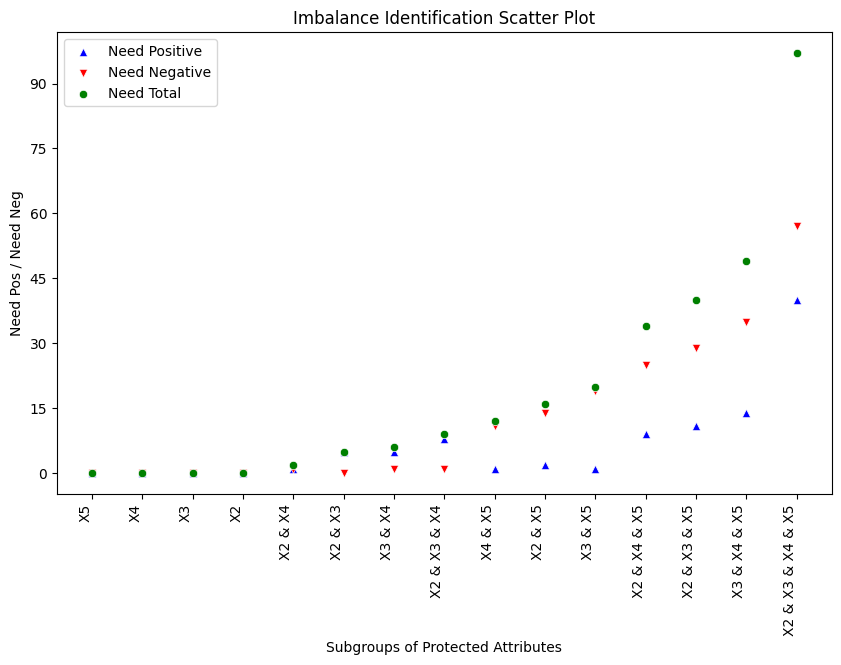

K:  30 imbalance threshold: 0.1


In [ ]:
data_ccc = pd.read_excel('default of credit card clients.xls')

# X2: SEX, X3: EDUCATION, X4: MARRIAGE, X5: AGE
columns_ccc = ['X2', 'X3', 'X4', 'X5']
ccc_y = 'Y'
X_ccc = pd.DataFrame(data_ccc)
run_tests(X_ccc, columns_ccc, ccc_y)